In [1]:
import numpy as np
import cv2 as cv
import random
import copy
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import json
import seaborn as sns
import plotly.express as px

from tqdm import tqdm

from pettingzoo.mpe import simple_v3
from pettingzoo.mpe import simple_tag_v3

import gymnasium as gym
import cv2 as cv


import tensorflow as tf
from tensorflow.keras import Model
import keras

from collections import Counter
from scipy import stats

In [2]:
n_actions = 5

In [3]:
def get_obs_model(comm_bits):
    return tf.keras.models.Sequential([
    # tf.keras.layers.Input(shape=(700,700,3)),
    tf.keras.layers.Input(shape=(4,)),
    # tf.keras.layers.Conv2D(6,3, strides=(3,3)),
    # tf.keras.layers.BatchNormalization(3),
    # tf.keras.layers.Conv2D(16,3),
    # tf.keras.layers.BatchNormalization(1),
    # tf.keras.layers.Conv2D(1,1),
    # tf.keras.layers.BatchNormalization(1),
    # tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(48, activation='linear'),
    tf.keras.layers.Dense(comm_bits, activation='linear'),
])

def get_exp_model(comm_bits):
    return tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(comm_bits,)),
    tf.keras.layers.Dense(comm_bits, activation='relu'),
    tf.keras.layers.Dense(48, activation='linear'),
    tf.keras.layers.Dense(5, activation='linear'),
])

In [4]:
@keras.saving.register_keras_serializable(package="MyLayers")
class observer_explorer_encoder(Model):
    def __init__(self, comm_bits):
        super(observer_explorer_encoder, self).__init__()
        self.obs_model = get_obs_model(comm_bits)
        self.exp_model = get_exp_model(comm_bits)

    def conv_bits(self, bits):
        ret = tf.cast(bits>0, bits.dtype)
        return ret

    def call(self, x, return_comm_bits=False):
        comms = self.obs_model(x)
        # comm_bits = self.conv_bits(comms)
        # comm_bits = tf.cast(comms>0, tf.int32)
        comm_bits = tf.stop_gradient(tf.cast(comms > 0, tf.float32) - tf.sigmoid(comms)) + tf.sigmoid(comms)
        output = self.exp_model(comm_bits)
        if return_comm_bits:
            return output, comm_bits
        return output

    def get_weights(self):
        w1, w2 = self.obs_model.get_weights(), self.exp_model.get_weights()
        return w1, w2
        
    def set_weights(self, ref_model):
        self.obs_model.set_weights(ref_model.obs_model.get_weights())
        self.exp_model.set_weights(ref_model.exp_model.get_weights())

In [5]:
def single_ep(env, eps):
    local_memory = []
    rews_ep = []
    for agent in env.agent_iter():
        state, reward, termination, truncation, info = env.last()
        if termination or truncation:
            action_ = None
        else:
            map_i = np.array([env.render()])
            if random.random() < eps:
                action_ = env.action_space(agent).sample()
                comm = None
            else:
                op1, comm = observer(np.array([state]), return_comm_bits=True)
 
                action_ = tf.argmax(op1, axis=1).numpy()[0]
        
        ret = env.step(action_)
        if action_ == None:
            break
        new_state, new_reward, _, _, _ = env.last()
        
        local_memory.append([
            state, action_, new_reward, new_state, comm
        ])
        rews_ep.append(new_reward)
    return local_memory, np.array(rews_ep)

In [6]:
def return_avg_reward(env, episodes=10, plot=False):
    rews = []
    for i in range(episodes):
        env.reset()
        a,b = single_ep(env, 0)
        rews.append(b)
    if plot:
        plt.plot(b)
        plt.show()
    return np.array(rews)

In [7]:
def single_ep_analyse(agent_model, env, eps):
    local_memory = []
    rews_ep = []
    for agent in env.agent_iter():
        state, reward, termination, truncation, info = env.last()
        if termination or truncation:
            action_ = None
        else:
            map_i = np.array([env.render()])
            if random.random() < eps:
                action_ = env.action_space(agent).sample()
                comm = None
            else:
                op1, comm = agent_model(np.array([state]), return_comm_bits=True)
 
                action_ = tf.argmax(op1, axis=1).numpy()[0]
        
        ret = env.step(action_)
        if action_ == None:
            break
        new_state, new_reward, _, _, _ = env.last()
        
        local_memory.append([
            state, action_, new_reward, new_state, comm
        ])
        rews_ep.append(new_reward)
    return local_memory, np.array(rews_ep)

In [8]:
def get_communication_props(observer, no_eps=1000):
    temp_mem = []
    for i in tqdm(range(no_eps)):
        env.reset()
        ret = single_ep_analyse(observer, env, 0)
        temp_mem.extend(ret[0])

    memory = temp_mem
    acts = [mem[1] for mem in memory]

    comm_dict = {}
    comm_dict_non_zero = {}
    comm_arrs = np.ones((len(memory))) * -1
    for i in range(len(memory)):
        s_i, a_i, r_i, s_j, comm_i = memory[i]
        if comm_i == None:
            continue
        comm_i = comm_i.numpy()[0].astype(int)
        key_comm = ''.join([str(x) for x in comm_i])
        if comm_dict.get(key_comm) is None:
            comm_dict[key_comm] = copy.deepcopy(comm_arrs)
            comm_arrs[i] = copy.deepcopy(a_i)
    
            comm_dict_non_zero[key_comm] = [a_i]
        else:
            comm_dict[key_comm][i] = a_i
    
            comm_dict_non_zero[key_comm].append(a_i)

    counter_comms = {}
    for i in comm_dict.keys():
        counter_comms[i] = dict(Counter(comm_dict_non_zero[i]))

    comm_prop_dict = {}
    for i in counter_comms.keys():
        temp = sum(list(counter_comms[i].values()))
        temp_prop = {
            x:counter_comms[i][x] / temp for x in counter_comms[i].keys()
        }
        comm_prop_dict[i] = temp_prop

    return comm_prop_dict

In [9]:
COMM_BITS = 16

env = simple_v3.env(render_mode="rgb_array")
env.reset()

memory = []
large_memory = []
eps = 0.9
eps_vals = []
avg_rew = []

opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)
opt2 = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)

observer = observer_explorer_encoder(comm_bits=COMM_BITS)
observer_ref = observer_explorer_encoder(comm_bits=COMM_BITS)

observer.compile(
    optimizer=opt,
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse']
)

observer_ref.compile(
    optimizer=opt2,
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse']
)

save_checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model_training.tf", monitor='mse', save_best_only=True)

2025-03-28 12:02:09.260156: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-03-28 12:02:09.260213: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-03-28 12:02:09.260223: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-03-28 12:02:09.260374: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-28 12:02:09.260710: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [747]:
pre_train = return_avg_reward(env, episodes=50)

In [748]:
temp = observer.obs_model.get_weights()

In [700]:
last_upd = [0]
for i in tqdm(range(300)):
    env.reset()
    a, b = single_ep(env, eps)
    memory.extend(a)
    avg_rew.append(b)
    eps_vals.append(eps)
    eps *= 0.99
    

    if len(memory) < 200:
        continue
    minibatch = random.sample(memory, 200)
    targets = []
    states = []
    for mem_i in minibatch:
        s_i, a_i, r_i, s_j, _ = mem_i
        yj = r_i + tf.math.scalar_mul(0.7, tf.cast(tf.argmax(observer_ref(np.array([s_j]))[0]), dtype=tf.float32))
        y_i = observer(np.array([s_i]))
        y_i = y_i.numpy()
        y_i[0][a_i] = yj
        targets.append(y_i[0])
        states.append(s_i)
    states = np.array(states)
    targets = np.array(targets)
    observer.fit(states, targets, epochs=1, shuffle=True, callbacks=[save_checkpoint])
    if i - last_upd[-1] > 10:
        observer_ref.set_weights(observer)
        last_upd.append(i)
    large_memory.extend(memory)
    # memory = []

  2%|█                                          | 7/300 [00:00<00:16, 18.30it/s]


KeyboardInterrupt: 

In [ ]:
plt.plot(last_upd)

In [ ]:
post_train = return_avg_reward(env, episodes=50)

In [ ]:
post_train.shape

In [ ]:
plt.figure(figsize=(10,8))

pre_train_mu = np.mean(pre_train, axis=0)
pre_train_std = np.std(pre_train, axis=0)

x = np.linspace(1,len(pre_train_mu),len(pre_train_mu))

post_train_mu = np.mean(post_train, axis=0)
post_train_std = np.std(post_train, axis=0)

plt.plot(x, pre_train_mu, label='Before training', color='b')
plt.plot(x, post_train_mu, label='After training', color='g')
plt.fill_between(x, pre_train_mu - pre_train_std, pre_train_mu + pre_train_std, alpha=0.4, color='b')
plt.fill_between(x, post_train_mu - post_train_std, post_train_std + post_train_std, alpha=0.4, color='g')
plt.xlabel("Step No.", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.ylim(-20, 6)
plt.title("Rewards for 25 steps across 50 episodes", fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [ ]:
sum_pre_train = [np.sum(i) for i in pre_train]
sum_post_train = [np.sum(i) for i in post_train]

In [ ]:
print(np.mean(sum_pre_train), ", ", np.std(sum_pre_train))
print(np.mean(sum_post_train), ", ", np.std(sum_post_train))

In [ ]:
plt.plot(eps_vals)

In [ ]:
rand_seed = random.randint(0,10000)

In [ ]:
env.reset(rand_seed)
rews = [i[2] for i in single_ep(env,0)[0]]
plt.plot(rews)

In [ ]:
env.reset(rand_seed)
acts = [i[1] for i in single_ep(env,0)[0]]
plt.plot(acts)

## Saving

In [ ]:
with open('obs_enc_model_' + str(COMM_BITS) + 'bit_memory.pkl', 'wb') as file:
	pickle.dump(large_memory, file)

In [ ]:
tf.keras.models.save_model(observer, "obs_enc_model_" + str(COMM_BITS) + "bit.keras")

In [ ]:
temp_obs = tf.keras.models.load_model("best_model_training.tf", compile=False)

In [ ]:
tf.keras.models.save_model(temp_obs, "obs_enc_model_" + str(COMM_BITS) + "bit_best.keras")

## Load and Analysis

In [ ]:
COMM_BITS = 8

In [ ]:
with open('obs_enc_model_' + str(COMM_BITS) + 'bit_memory.pkl', 'rb') as file:
	large_memory = pickle.load(file)

In [ ]:
model = tf.keras.models.load_model("obs_enc_model_" + str(COMM_BITS) + "bit.keras", compile=False)

In [ ]:
observer = model

In [ ]:
comm_prop_dict_1 = get_communication_props(observer)

In [ ]:
df = pd.DataFrame.from_dict(comm_prop_dict_1, orient='index')
df = df.fillna(0).T

df_sorted = df.sort_index(ascending=False)
cg = sns.clustermap(df_sorted, cmap="vlag", method="average", metric="euclidean", col_cluster=True, row_cluster=False, cbar_pos=(0.1, 0.5, 0.03, 0.2))
cg.ax_col_dendrogram.set_visible(False)
plt.title("Heatmap of Communication Bits and their significance on actions - "+str(COMM_BITS)+" bits", y=2, x=15)
plt.show()

In [ ]:
env = simple_v3.env(render_mode="rgb_array")
env.reset()

memory = []
large_memory = []
eps = 0.9
eps_vals = []
avg_rew = []

opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)
opt2 = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)

observer_ref = observer_explorer_encoder(comm_bits=COMM_BITS)
observer_ref.set_weights(observer)

observer.compile(
    optimizer=opt,
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse']
)

observer_ref.compile(
    optimizer=opt2,
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse']
)

save_checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model_training.tf", monitor='mse', save_best_only=True)

In [ ]:
pre_train = return_avg_reward(env, episodes=50)

In [ ]:
temp = observer.obs_model.get_weights()

In [ ]:
last_upd = [0]
for i in tqdm(range(100)):
    env.reset()
    a, b = single_ep(env, eps)
    memory.extend(a)
    avg_rew.append(b)
    eps_vals.append(eps)
    eps *= 0.99
    

    if len(memory) < 200:
        continue
    minibatch = random.sample(memory, 200)
    targets = []
    states = []
    for mem_i in minibatch:
        s_i, a_i, r_i, s_j, _ = mem_i
        yj = r_i + tf.math.scalar_mul(0.7, tf.cast(tf.argmax(observer_ref(np.array([s_j]))[0]), dtype=tf.float32))
        y_i = observer(np.array([s_i]))
        y_i = y_i.numpy()
        y_i[0][a_i] = yj
        targets.append(y_i[0])
        states.append(s_i)
    states = np.array(states)
    targets = np.array(targets)
    observer.fit(states, targets, epochs=1, shuffle=True, callbacks=[save_checkpoint])
    if i - last_upd[-1] > 10:
        observer_ref.set_weights(observer)
        last_upd.append(i)
    large_memory.extend(memory)
    # memory = []

In [ ]:
plt.plot(last_upd)

In [ ]:
post_train = return_avg_reward(env, episodes=50)

In [ ]:
post_train.shape

In [ ]:
plt.figure(figsize=(10,8))

pre_train_mu = np.mean(pre_train, axis=0)
pre_train_std = np.std(pre_train, axis=0)

x = np.linspace(1,len(pre_train_mu),len(pre_train_mu))

post_train_mu = np.mean(post_train, axis=0)
post_train_std = np.std(post_train, axis=0)

plt.plot(x, pre_train_mu, label='Before training', color='b')
plt.plot(x, post_train_mu, label='After training', color='g')
plt.fill_between(x, pre_train_mu - pre_train_std, pre_train_mu + pre_train_std, alpha=0.4, color='b')
plt.fill_between(x, post_train_mu - post_train_std, post_train_std + post_train_std, alpha=0.4, color='g')
plt.xlabel("Step No.", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.ylim(-20, 6)
plt.title("Rewards for 25 steps across 50 episodes", fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [ ]:
sum_pre_train = [np.sum(i) for i in pre_train]
sum_post_train = [np.sum(i) for i in post_train]

In [ ]:
print(np.mean(sum_pre_train), ", ", np.std(sum_pre_train))
print(np.mean(sum_post_train), ", ", np.std(sum_post_train))

In [ ]:
comm_prop_dict_2 = get_communication_props(observer)

In [ ]:
len(comm_prop_dict_1.keys())

In [ ]:
len(comm_prop_dict_2.keys())

In [ ]:
df_vals = []
all_keys = list(comm_prop_dict_2.keys())
all_keys.extend(comm_prop_dict_1.keys())
all_keys = list(set(all_keys))

In [ ]:
ct = 0
common_ct = 0
for i in all_keys:
    temp = [i]
    if not comm_prop_dict_1.get(i) is None:
        temp.append(list(comm_prop_dict_1[i].keys())[0])
    else:
        temp.append(-1)

    if not comm_prop_dict_2.get(i) is None:
        temp.append(list(comm_prop_dict_2[i].keys())[0])
    else:
        temp.append(-1)
    if temp[-1] != temp[-2] and temp[-1]>=0 and temp[-2] >= 0:
        ct +=1
    elif temp[-1] >=0 and temp[-2]>=0:
        common_ct+=1
    df_vals.append(temp)

In [ ]:
ct

In [ ]:
common_ct

In [ ]:
temp_df = pd.DataFrame(df_vals, columns=["Bits", "Before", "After"])

In [ ]:
temp_df.to_csv("analysis_comm_change_lowLR001_8bits.csv")

In [ ]:
temp_df

In [ ]:
len(np.where(temp_df['Before'] == -1)[0])

In [ ]:
len(np.where(temp_df['After'] == -1)[0])

In [ ]:
temp_mem = []
for i in tqdm(range(1000)):
    env.reset()
    ret = single_ep(env, 0)
    temp_mem.extend(ret[0])

In [ ]:
memory = temp_mem

In [ ]:
len(memory)

In [ ]:
acts = [mem[1] for mem in memory]

In [ ]:
comm_dict = {}
comm_dict_non_zero = {}
comm_arrs = np.ones((len(memory))) * -1
print(comm_arrs.shape)
for i in range(len(memory)):
    s_i, a_i, r_i, s_j, comm_i = memory[i]
    if comm_i == None:
        continue
    comm_i = comm_i.numpy()[0].astype(int)
    key_comm = ''.join([str(x) for x in comm_i])
    if comm_dict.get(key_comm) is None:
        comm_dict[key_comm] = copy.deepcopy(comm_arrs)
        comm_arrs[i] = copy.deepcopy(a_i)

        comm_dict_non_zero[key_comm] = [a_i]
    else:
        comm_dict[key_comm][i] = a_i

        comm_dict_non_zero[key_comm].append(a_i)

# for i in comm_dict.keys():
#     comm_dict[i] = list(comm_dict[i])

In [ ]:
counter_comms = {}
for i in comm_dict.keys():
    counter_comms[i] = dict(Counter(comm_dict_non_zero[i]))

In [ ]:
counter_comms

In [ ]:
print(len(counter_comms.keys()))

In [ ]:
comm_prop_dict = {}
for i in counter_comms.keys():
    print(i, " - ",counter_comms[i])
    temp = sum(list(counter_comms[i].values()))
    temp_prop = {
        x:counter_comms[i][x] / temp for x in counter_comms[i].keys()
    }
    print(temp_prop)
    comm_prop_dict[i] = temp_prop

In [ ]:
comm_prop_dict

In [ ]:
comm_prop_dict['11001100']

In [ ]:
df = pd.DataFrame.from_dict(comm_prop_dict, orient='index')
df = df.fillna(0).T

In [ ]:
df_sorted = df.sort_index(ascending=False)
cg = sns.clustermap(df_sorted, cmap="vlag", method="average", metric="euclidean", col_cluster=True, row_cluster=False, cbar_pos=(0.1, 0.5, 0.03, 0.2))
cg.ax_col_dendrogram.set_visible(False)
plt.title("Heatmap of Communication Bits and their significance on actions - "+str(COMM_BITS)+" bits", y=2, x=15)
plt.show()

## Language evolution

In [97]:
COMM_BITS = 8

In [98]:
model = tf.keras.models.load_model("obs_enc_model_" + str(COMM_BITS) + "bit.keras", compile=False)

In [99]:
env = simple_v3.env(render_mode="rgb_array")
env.reset()

memory = []
large_memory = []
eps = 0.9
lr = 0.01
eps_vals = []
avg_rew = []

opt = tf.keras.optimizers.legacy.SGD(learning_rate=lr)
opt2 = tf.keras.optimizers.legacy.SGD(learning_rate=lr)

observer = observer_explorer_encoder(comm_bits=COMM_BITS)
observer_ref = observer_explorer_encoder(comm_bits=COMM_BITS)

observer.set_weights(model)
observer_ref.set_weights(model)

observer.compile(
    optimizer=opt,
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse']
)

observer_ref.compile(
    optimizer=opt2,
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse']
)

save_checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model_training.tf", monitor='mse', save_best_only=True)

In [100]:
pre_train = return_avg_reward(env, episodes=50)

In [101]:
temp = observer.obs_model.get_weights()

In [102]:
last_upd = [0]
for i in tqdm(range(200)):
    env.reset()
    a, b = single_ep(env, eps)
    memory.extend(a)
    avg_rew.append(b)
    eps_vals.append(eps)
    eps *= 0.99
    

    if len(memory) < 200:
        continue
    minibatch = random.sample(memory, 200)
    targets = []
    states = []
    for mem_i in minibatch:
        s_i, a_i, r_i, s_j, _ = mem_i
        yj = r_i + tf.math.scalar_mul(0.7, tf.cast(tf.argmax(observer_ref(np.array([s_j]))[0]), dtype=tf.float32))
        y_i = observer(np.array([s_i]))
        y_i = y_i.numpy()
        y_i[0][a_i] = yj
        targets.append(y_i[0])
        states.append(s_i)
    states = np.array(states)
    targets = np.array(targets)
    observer.fit(states, targets, epochs=1, shuffle=True, callbacks=[save_checkpoint])
    if i - last_upd[-1] > 10:
        observer_ref.set_weights(observer)
        last_upd.append(i)
    large_memory.extend(memory)
    # memory = []

  3%|█▎                                         | 6/200 [00:00<00:08, 23.70it/s]

7/7 [==============================] - ETA: 0s - loss: 0.4519 - mse: 0.4519

2025-03-28 13:58:53.998019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: best_model_training.tf/assets


INFO:tensorflow:Assets written to: best_model_training.tf/assets


1/7 [===>..........................] - ETA: 0s - loss: 0.4832 - mse: 0.4832INFO:tensorflow:Assets written to: best_model_training.tf/assets


INFO:tensorflow:Assets written to: best_model_training.tf/assets


7/7 [==============================] - 0s 60ms/step - loss: 0.3926 - mse: 0.3926


  4%|█▉                                         | 9/200 [00:03<01:30,  2.12it/s]

1/7 [===>..........................] - ETA: 0s - loss: 0.4067 - mse: 0.4067INFO:tensorflow:Assets written to: best_model_training.tf/assets


INFO:tensorflow:Assets written to: best_model_training.tf/assets


7/7 [==============================] - 0s 44ms/step - loss: 0.3722 - mse: 0.3722


  6%|██▎                                       | 11/200 [00:05<02:08,  1.47it/s]

7/7 [==============================] - 0s 4ms/step - loss: 0.3823 - mse: 0.3823


  6%|██▌                                       | 12/200 [00:06<02:23,  1.31it/s]

1/7 [===>..........................] - ETA: 0s - loss: 0.2021 - mse: 0.2021INFO:tensorflow:Assets written to: best_model_training.tf/assets


INFO:tensorflow:Assets written to: best_model_training.tf/assets


7/7 [==============================] - 0s 42ms/step - loss: 0.2849 - mse: 0.2849


  6%|██▋                                       | 13/200 [00:07<02:40,  1.16it/s]

7/7 [==============================] - 0s 4ms/step - loss: 0.3559 - mse: 0.3559


  7%|██▉                                       | 14/200 [00:08<02:47,  1.11it/s]

7/7 [==============================] - 0s 4ms/step - loss: 0.2945 - mse: 0.2945


  8%|███▏                                      | 15/200 [00:10<02:53,  1.07it/s]

1/7 [===>..........................] - ETA: 0s - loss: 0.2661 - mse: 0.2661INFO:tensorflow:Assets written to: best_model_training.tf/assets


INFO:tensorflow:Assets written to: best_model_training.tf/assets


7/7 [==============================] - 0s 40ms/step - loss: 0.2828 - mse: 0.2828


  8%|███▎                                      | 16/200 [00:11<03:06,  1.01s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.3151 - mse: 0.3151


  8%|███▌                                      | 17/200 [00:12<03:14,  1.06s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.3592 - mse: 0.3592


  9%|███▊                                      | 18/200 [00:13<03:15,  1.07s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.4098 - mse: 0.4098


 10%|███▉                                      | 19/200 [00:14<03:11,  1.06s/it]

7/7 [==============================] - 0s 3ms/step - loss: 0.4073 - mse: 0.4073


 10%|████▏                                     | 20/200 [00:15<03:06,  1.04s/it]

7/7 [==============================] - 0s 3ms/step - loss: 0.4978 - mse: 0.4978


 10%|████▍                                     | 21/200 [00:16<03:04,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.4439 - mse: 0.4439


 11%|████▌                                     | 22/200 [00:17<03:05,  1.04s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.3935 - mse: 0.3935


 12%|████▊                                     | 23/200 [00:18<03:06,  1.06s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.4284 - mse: 0.4284


 12%|█████                                     | 24/200 [00:19<03:07,  1.07s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.5159 - mse: 0.5159


 12%|█████▎                                    | 25/200 [00:20<03:05,  1.06s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.5359 - mse: 0.5359


 13%|█████▍                                    | 26/200 [00:21<03:02,  1.05s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.6925 - mse: 0.6925


 14%|█████▋                                    | 27/200 [00:22<03:00,  1.05s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.5051 - mse: 0.5051


 14%|█████▉                                    | 28/200 [00:23<02:59,  1.04s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.5736 - mse: 0.5736


 14%|██████                                    | 29/200 [00:24<02:57,  1.04s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.6193 - mse: 0.6193


 15%|██████▎                                   | 30/200 [00:26<02:55,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.7095 - mse: 0.7095


 16%|██████▌                                   | 31/200 [00:27<02:53,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.5752 - mse: 0.5752


 16%|██████▋                                   | 32/200 [00:28<02:51,  1.02s/it]

7/7 [==============================] - 0s 5ms/step - loss: 0.5508 - mse: 0.5508


 16%|██████▉                                   | 33/200 [00:29<02:52,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.5507 - mse: 0.5507


 17%|███████▏                                  | 34/200 [00:30<03:04,  1.11s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.4723 - mse: 0.4723


 18%|███████▎                                  | 35/200 [00:31<03:05,  1.13s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.5839 - mse: 0.5839


 18%|███████▌                                  | 36/200 [00:32<03:00,  1.10s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.4731 - mse: 0.4731


 18%|███████▊                                  | 37/200 [00:33<02:59,  1.10s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.6146 - mse: 0.6146


 19%|███████▉                                  | 38/200 [00:34<03:00,  1.11s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.4931 - mse: 0.4931


 20%|████████▏                                 | 39/200 [00:36<03:03,  1.14s/it]

7/7 [==============================] - 0s 3ms/step - loss: 0.5761 - mse: 0.5761


 20%|████████▍                                 | 40/200 [00:37<03:02,  1.14s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.6114 - mse: 0.6114


 20%|████████▌                                 | 41/200 [00:38<02:57,  1.12s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.7068 - mse: 0.7068


 21%|████████▊                                 | 42/200 [00:39<02:51,  1.09s/it]

7/7 [==============================] - 0s 3ms/step - loss: 0.6025 - mse: 0.6025


 22%|█████████                                 | 43/200 [00:40<02:50,  1.08s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.6609 - mse: 0.6609


 22%|█████████▏                                | 44/200 [00:41<02:45,  1.06s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.4610 - mse: 0.4610


 22%|█████████▍                                | 45/200 [00:42<02:42,  1.05s/it]

7/7 [==============================] - 0s 3ms/step - loss: 0.6257 - mse: 0.6257


 23%|█████████▋                                | 46/200 [00:43<02:39,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.6154 - mse: 0.6154


 24%|█████████▊                                | 47/200 [00:44<02:41,  1.06s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.6005 - mse: 0.6005


 24%|██████████                                | 48/200 [00:45<02:38,  1.05s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.8354 - mse: 0.8354


 24%|██████████▎                               | 49/200 [00:46<02:40,  1.06s/it]

7/7 [==============================] - 0s 5ms/step - loss: 0.7148 - mse: 0.7148


 25%|██████████▌                               | 50/200 [00:47<02:45,  1.10s/it]

7/7 [==============================] - 0s 3ms/step - loss: 0.8513 - mse: 0.8513


 26%|██████████▋                               | 51/200 [00:48<02:43,  1.10s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.9347 - mse: 0.9347


 26%|██████████▉                               | 52/200 [00:49<02:39,  1.07s/it]

7/7 [==============================] - 0s 5ms/step - loss: 0.9854 - mse: 0.9854


 26%|███████████▏                              | 53/200 [00:50<02:39,  1.08s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.1843 - mse: 1.1843


 27%|███████████▎                              | 54/200 [00:52<02:43,  1.12s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.0226 - mse: 1.0226


 28%|███████████▌                              | 55/200 [00:53<02:39,  1.10s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.3456 - mse: 1.3456


 28%|███████████▊                              | 56/200 [00:54<02:34,  1.07s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.3270 - mse: 1.3270


 28%|███████████▉                              | 57/200 [00:55<02:32,  1.07s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.9643 - mse: 0.9643


 29%|████████████▏                             | 58/200 [00:56<02:40,  1.13s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.2912 - mse: 1.2912


 30%|████████████▍                             | 59/200 [00:57<02:36,  1.11s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.9145 - mse: 1.9145


 30%|████████████▌                             | 60/200 [00:58<02:31,  1.08s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.1328 - mse: 1.1328


 30%|████████████▊                             | 61/200 [00:59<02:28,  1.07s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.5178 - mse: 1.5178


 31%|█████████████                             | 62/200 [01:00<02:26,  1.06s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.2091 - mse: 1.2091


 32%|█████████████▏                            | 63/200 [01:01<02:26,  1.07s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.3095 - mse: 1.3095


 32%|█████████████▍                            | 64/200 [01:02<02:22,  1.05s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.2819 - mse: 1.2819


 32%|█████████████▋                            | 65/200 [01:03<02:25,  1.08s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.0009 - mse: 1.0009


 33%|█████████████▊                            | 66/200 [01:04<02:21,  1.06s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.3856 - mse: 1.3856


 34%|██████████████                            | 67/200 [01:06<02:21,  1.07s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.6094 - mse: 1.6094


 34%|██████████████▎                           | 68/200 [01:07<02:23,  1.09s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.1825 - mse: 1.1825


 34%|██████████████▍                           | 69/200 [01:08<02:21,  1.08s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.2994 - mse: 1.2994


 35%|██████████████▋                           | 70/200 [01:09<02:17,  1.06s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.6955 - mse: 1.6955


 36%|██████████████▉                           | 71/200 [01:10<02:20,  1.09s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.2670 - mse: 1.2670


 36%|███████████████                           | 72/200 [01:11<02:23,  1.12s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.2734 - mse: 1.2734


 36%|███████████████▎                          | 73/200 [01:12<02:22,  1.13s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.2118 - mse: 1.2118


 37%|███████████████▌                          | 74/200 [01:13<02:17,  1.09s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.6914 - mse: 1.6914


 38%|███████████████▊                          | 75/200 [01:14<02:14,  1.08s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.5601 - mse: 1.5601


 38%|███████████████▉                          | 76/200 [01:15<02:12,  1.07s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.0564 - mse: 1.0564


 38%|████████████████▏                         | 77/200 [01:16<02:09,  1.05s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.0023 - mse: 1.0023


 39%|████████████████▍                         | 78/200 [01:17<02:08,  1.05s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.0352 - mse: 1.0352


 40%|████████████████▌                         | 79/200 [01:18<02:05,  1.04s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.1807 - mse: 1.1807


 40%|████████████████▊                         | 80/200 [01:19<02:03,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.4916 - mse: 1.4916


 40%|█████████████████                         | 81/200 [01:20<02:02,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.0127 - mse: 1.0127


 41%|█████████████████▏                        | 82/200 [01:22<02:01,  1.03s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.7529 - mse: 1.7529


 42%|█████████████████▍                        | 83/200 [01:23<01:59,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.2142 - mse: 1.2142


 42%|█████████████████▋                        | 84/200 [01:24<01:58,  1.02s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.3941 - mse: 1.3941


 42%|█████████████████▊                        | 85/200 [01:25<01:56,  1.01s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.2872 - mse: 1.2872


 43%|██████████████████                        | 86/200 [01:26<01:55,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.6236 - mse: 1.6236


 44%|██████████████████▎                       | 87/200 [01:27<01:55,  1.02s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.2125 - mse: 1.2125


 44%|██████████████████▍                       | 88/200 [01:28<01:54,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 0.8969 - mse: 0.8969


 44%|██████████████████▋                       | 89/200 [01:29<01:54,  1.03s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.4348 - mse: 1.4348


 45%|██████████████████▉                       | 90/200 [01:30<01:53,  1.03s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.7757 - mse: 1.7757


 46%|███████████████████                       | 91/200 [01:31<01:52,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.5931 - mse: 1.5931


 46%|███████████████████▎                      | 92/200 [01:32<01:50,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.9061 - mse: 1.9061


 46%|███████████████████▌                      | 93/200 [01:33<01:49,  1.02s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.7798 - mse: 1.7798


 47%|███████████████████▋                      | 94/200 [01:34<01:47,  1.02s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.7699 - mse: 1.7699


 48%|███████████████████▉                      | 95/200 [01:35<01:47,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.7133 - mse: 1.7133


 48%|████████████████████▏                     | 96/200 [01:36<01:47,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.9593 - mse: 1.9593


 48%|████████████████████▎                     | 97/200 [01:37<01:45,  1.02s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.9042 - mse: 1.9042


 49%|████████████████████▌                     | 98/200 [01:38<01:43,  1.02s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.6991 - mse: 1.6991


 50%|████████████████████▊                     | 99/200 [01:39<01:42,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.4496 - mse: 1.4496


 50%|████████████████████▌                    | 100/200 [01:40<01:42,  1.02s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.3523 - mse: 1.3523


 50%|████████████████████▋                    | 101/200 [01:41<01:41,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.3882 - mse: 1.3882


 51%|████████████████████▉                    | 102/200 [01:42<01:39,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.3244 - mse: 1.3244


 52%|█████████████████████                    | 103/200 [01:43<01:38,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.6945 - mse: 1.6945


 52%|█████████████████████▎                   | 104/200 [01:44<01:37,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.3952 - mse: 2.3952


 52%|█████████████████████▌                   | 105/200 [01:45<01:37,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.0364 - mse: 2.0364


 53%|█████████████████████▋                   | 106/200 [01:46<01:39,  1.06s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.0517 - mse: 2.0517


 54%|█████████████████████▉                   | 107/200 [01:47<01:40,  1.08s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.2174 - mse: 1.2174


 54%|██████████████████████▏                  | 108/200 [01:48<01:37,  1.06s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.4424 - mse: 2.4424


 55%|██████████████████████▎                  | 109/200 [01:49<01:36,  1.06s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.1147 - mse: 1.1147


 55%|██████████████████████▌                  | 110/200 [01:50<01:35,  1.06s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.5735 - mse: 1.5735


 56%|██████████████████████▊                  | 111/200 [01:51<01:33,  1.05s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.9499 - mse: 1.9499


 56%|██████████████████████▉                  | 112/200 [01:52<01:31,  1.04s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.0579 - mse: 2.0579


 56%|███████████████████████▏                 | 113/200 [01:53<01:29,  1.03s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.2568 - mse: 2.2568


 57%|███████████████████████▎                 | 114/200 [01:54<01:28,  1.03s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.2896 - mse: 2.2896


 57%|███████████████████████▌                 | 115/200 [01:55<01:26,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.4580 - mse: 1.4580


 58%|███████████████████████▊                 | 116/200 [01:57<01:25,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.7497 - mse: 1.7497


 58%|███████████████████████▉                 | 117/200 [01:58<01:24,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.2399 - mse: 2.2399


 59%|████████████████████████▏                | 118/200 [01:59<01:23,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.3838 - mse: 2.3838


 60%|████████████████████████▍                | 119/200 [02:00<01:22,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.3788 - mse: 2.3788


 60%|████████████████████████▌                | 120/200 [02:01<01:21,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.6030 - mse: 2.6030


 60%|████████████████████████▊                | 121/200 [02:02<01:21,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.2264 - mse: 2.2264


 61%|█████████████████████████                | 122/200 [02:03<01:20,  1.03s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.0083 - mse: 2.0083


 62%|█████████████████████████▏               | 123/200 [02:04<01:21,  1.06s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.7873 - mse: 1.7873


 62%|█████████████████████████▍               | 124/200 [02:05<01:19,  1.04s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.7338 - mse: 1.7338


 62%|█████████████████████████▋               | 125/200 [02:06<01:23,  1.11s/it]

7/7 [==============================] - 0s 7ms/step - loss: 1.7731 - mse: 1.7731


 63%|█████████████████████████▊               | 126/200 [02:07<01:26,  1.17s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.5780 - mse: 1.5780


 64%|██████████████████████████               | 127/200 [02:09<01:28,  1.21s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.5599 - mse: 1.5599


 64%|██████████████████████████▏              | 128/200 [02:10<01:22,  1.15s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.6868 - mse: 1.6868


 64%|██████████████████████████▍              | 129/200 [02:11<01:18,  1.11s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.8423 - mse: 1.8423


 65%|██████████████████████████▋              | 130/200 [02:12<01:15,  1.08s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.4678 - mse: 2.4678


 66%|██████████████████████████▊              | 131/200 [02:13<01:13,  1.06s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.2135 - mse: 2.2135


 66%|███████████████████████████              | 132/200 [02:14<01:10,  1.04s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.5779 - mse: 1.5779


 66%|███████████████████████████▎             | 133/200 [02:15<01:09,  1.03s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.6528 - mse: 1.6528


 67%|███████████████████████████▍             | 134/200 [02:16<01:07,  1.03s/it]

7/7 [==============================] - 0s 5ms/step - loss: 2.3129 - mse: 2.3129


 68%|███████████████████████████▋             | 135/200 [02:17<01:09,  1.07s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.1323 - mse: 2.1323


 68%|███████████████████████████▉             | 136/200 [02:18<01:12,  1.13s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.1569 - mse: 2.1569


 68%|████████████████████████████             | 137/200 [02:19<01:09,  1.10s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.8793 - mse: 1.8793


 69%|████████████████████████████▎            | 138/200 [02:20<01:06,  1.08s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.9689 - mse: 1.9689


 70%|████████████████████████████▍            | 139/200 [02:21<01:04,  1.06s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.3538 - mse: 2.3538


 70%|████████████████████████████▋            | 140/200 [02:22<01:02,  1.04s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.6139 - mse: 2.6139


 70%|████████████████████████████▉            | 141/200 [02:23<01:01,  1.04s/it]

7/7 [==============================] - 0s 3ms/step - loss: 3.0077 - mse: 3.0077


 71%|█████████████████████████████            | 142/200 [02:24<00:59,  1.03s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.2135 - mse: 2.2135


 72%|█████████████████████████████▎           | 143/200 [02:25<00:58,  1.03s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.6610 - mse: 1.6610


 72%|█████████████████████████████▌           | 144/200 [02:26<00:57,  1.02s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.8708 - mse: 1.8708


 72%|█████████████████████████████▋           | 145/200 [02:27<00:56,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.5116 - mse: 1.5116


 73%|█████████████████████████████▉           | 146/200 [02:28<00:55,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.9974 - mse: 1.9974


 74%|██████████████████████████████▏          | 147/200 [02:29<00:53,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.7092 - mse: 1.7092


 74%|██████████████████████████████▎          | 148/200 [02:30<00:52,  1.02s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.7790 - mse: 1.7790


 74%|██████████████████████████████▌          | 149/200 [02:31<00:51,  1.02s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.7270 - mse: 2.7270


 75%|██████████████████████████████▊          | 150/200 [02:32<00:51,  1.02s/it]

7/7 [==============================] - 0s 3ms/step - loss: 3.1517 - mse: 3.1517


 76%|██████████████████████████████▉          | 151/200 [02:33<00:49,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.9443 - mse: 1.9443


 76%|███████████████████████████████▏         | 152/200 [02:35<00:49,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.5894 - mse: 1.5894


 76%|███████████████████████████████▎         | 153/200 [02:36<00:48,  1.02s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.6006 - mse: 1.6006


 77%|███████████████████████████████▌         | 154/200 [02:37<00:46,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.8955 - mse: 1.8955


 78%|███████████████████████████████▊         | 155/200 [02:38<00:46,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.9004 - mse: 1.9004


 78%|███████████████████████████████▉         | 156/200 [02:39<00:44,  1.02s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.0053 - mse: 2.0053


 78%|████████████████████████████████▏        | 157/200 [02:40<00:44,  1.02s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.1430 - mse: 2.1430


 79%|████████████████████████████████▍        | 158/200 [02:41<00:43,  1.05s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.5863 - mse: 1.5863


 80%|████████████████████████████████▌        | 159/200 [02:42<00:42,  1.04s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.2488 - mse: 1.2488


 80%|████████████████████████████████▊        | 160/200 [02:43<00:41,  1.04s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.4148 - mse: 1.4148


 80%|█████████████████████████████████        | 161/200 [02:44<00:40,  1.04s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.8144 - mse: 1.8144


 81%|█████████████████████████████████▏       | 162/200 [02:45<00:39,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.6160 - mse: 1.6160


 82%|█████████████████████████████████▍       | 163/200 [02:46<00:38,  1.03s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.9819 - mse: 1.9819


 82%|█████████████████████████████████▌       | 164/200 [02:47<00:36,  1.03s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.8733 - mse: 1.8733


 82%|█████████████████████████████████▊       | 165/200 [02:48<00:36,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.0266 - mse: 1.0266


 83%|██████████████████████████████████       | 166/200 [02:49<00:34,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.5455 - mse: 2.5455


 84%|██████████████████████████████████▏      | 167/200 [02:50<00:33,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.5609 - mse: 2.5609


 84%|██████████████████████████████████▍      | 168/200 [02:51<00:33,  1.04s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.1809 - mse: 2.1809


 84%|██████████████████████████████████▋      | 169/200 [02:52<00:32,  1.06s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.5981 - mse: 2.5981


 85%|██████████████████████████████████▊      | 170/200 [02:53<00:31,  1.05s/it]

7/7 [==============================] - 0s 4ms/step - loss: 3.1923 - mse: 3.1923


 86%|███████████████████████████████████      | 171/200 [02:54<00:30,  1.05s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.1203 - mse: 2.1203


 86%|███████████████████████████████████▎     | 172/200 [02:55<00:29,  1.05s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.9165 - mse: 1.9165


 86%|███████████████████████████████████▍     | 173/200 [02:56<00:28,  1.04s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.4983 - mse: 2.4983


 87%|███████████████████████████████████▋     | 174/200 [02:57<00:27,  1.04s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.6537 - mse: 1.6537


 88%|███████████████████████████████████▉     | 175/200 [02:58<00:25,  1.04s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.6255 - mse: 2.6255


 88%|████████████████████████████████████     | 176/200 [02:59<00:24,  1.04s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.4507 - mse: 2.4507


 88%|████████████████████████████████████▎    | 177/200 [03:01<00:24,  1.06s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.3339 - mse: 2.3339


 89%|████████████████████████████████████▍    | 178/200 [03:02<00:23,  1.06s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.7515 - mse: 1.7515


 90%|████████████████████████████████████▋    | 179/200 [03:03<00:22,  1.05s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.6849 - mse: 1.6849


 90%|████████████████████████████████████▉    | 180/200 [03:04<00:20,  1.05s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.5550 - mse: 1.5550


 90%|█████████████████████████████████████    | 181/200 [03:05<00:19,  1.04s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.3776 - mse: 1.3776


 91%|█████████████████████████████████████▎   | 182/200 [03:06<00:18,  1.04s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.7506 - mse: 2.7506


 92%|█████████████████████████████████████▌   | 183/200 [03:07<00:17,  1.04s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.8499 - mse: 2.8499


 92%|█████████████████████████████████████▋   | 184/200 [03:08<00:16,  1.04s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.7280 - mse: 1.7280


 92%|█████████████████████████████████████▉   | 185/200 [03:09<00:15,  1.05s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.1868 - mse: 2.1868


 93%|██████████████████████████████████████▏  | 186/200 [03:10<00:14,  1.04s/it]

7/7 [==============================] - 0s 3ms/step - loss: 1.8825 - mse: 1.8825


 94%|██████████████████████████████████████▎  | 187/200 [03:11<00:13,  1.05s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.4229 - mse: 1.4229


 94%|██████████████████████████████████████▌  | 188/200 [03:12<00:12,  1.05s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.5771 - mse: 1.5771


 94%|██████████████████████████████████████▋  | 189/200 [03:13<00:11,  1.04s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.2612 - mse: 2.2612


 95%|██████████████████████████████████████▉  | 190/200 [03:14<00:10,  1.04s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.0590 - mse: 2.0590


 96%|███████████████████████████████████████▏ | 191/200 [03:15<00:09,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.2563 - mse: 2.2563


 96%|███████████████████████████████████████▎ | 192/200 [03:16<00:08,  1.04s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.5828 - mse: 2.5828


 96%|███████████████████████████████████████▌ | 193/200 [03:17<00:07,  1.05s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.8557 - mse: 1.8557


 97%|███████████████████████████████████████▊ | 194/200 [03:18<00:06,  1.05s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.9788 - mse: 1.9788


 98%|███████████████████████████████████████▉ | 195/200 [03:19<00:05,  1.05s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.1593 - mse: 2.1593


 98%|████████████████████████████████████████▏| 196/200 [03:20<00:04,  1.04s/it]

7/7 [==============================] - 0s 4ms/step - loss: 1.5394 - mse: 1.5394


 98%|████████████████████████████████████████▍| 197/200 [03:21<00:03,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.1788 - mse: 2.1788


 99%|████████████████████████████████████████▌| 198/200 [03:22<00:02,  1.03s/it]

7/7 [==============================] - 0s 4ms/step - loss: 2.9061 - mse: 2.9061


100%|████████████████████████████████████████▊| 199/200 [03:23<00:01,  1.03s/it]

7/7 [==============================] - 0s 3ms/step - loss: 2.3772 - mse: 2.3772


100%|█████████████████████████████████████████| 200/200 [03:24<00:00,  1.02s/it]


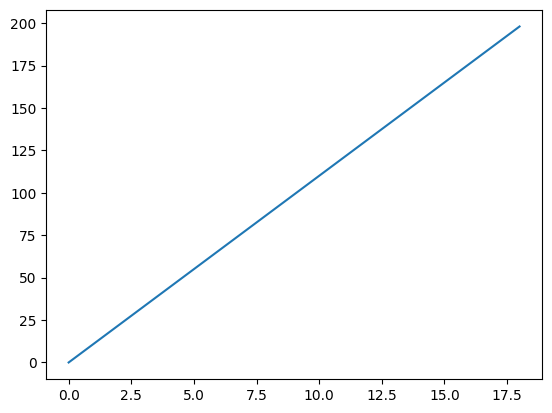

In [40]:
plt.plot(last_upd)

In [103]:
tf.keras.models.save_model(observer, "obs_enc_model_" + str(COMM_BITS) + "bit_lang_ev_01.keras")

### Analysis

In [162]:
COMM_BITS = 16

In [163]:

model1 = tf.keras.models.load_model("obs_enc_model_" + str(COMM_BITS) + "bit_lang_ev_01.keras", compile=False)
model2 = tf.keras.models.load_model("obs_enc_model_" + str(COMM_BITS) + "bit_lang_ev_001.keras", compile=False)
model3 = tf.keras.models.load_model("obs_enc_model_" + str(COMM_BITS) + "bit_lang_ev_0001.keras", compile=False)

In [164]:
model = tf.keras.models.load_model("obs_enc_model_" + str(COMM_BITS) + "bit.keras", compile=False)

In [165]:
base_comm = get_communication_props(model)

100%|███████████████████████████████████████| 1000/1000 [01:25<00:00, 11.65it/s]


In [166]:
comm_1 = get_communication_props(model1)

100%|███████████████████████████████████████| 1000/1000 [01:25<00:00, 11.69it/s]


In [167]:
comm_2 = get_communication_props(model2)

100%|███████████████████████████████████████| 1000/1000 [01:25<00:00, 11.64it/s]


In [168]:
comm_3 = get_communication_props(model3)

100%|███████████████████████████████████████| 1000/1000 [01:26<00:00, 11.62it/s]


In [188]:
common_comm = []
base_only = []
new_only = []

base_keys = list(base_comm.keys())
for i in comm_3.keys():
    if i in base_keys:
        common_comm.append(i)
    else:
        new_only.append(i)

for i in base_comm.keys():
    if i in list(comm_3.keys()):
        continue
    base_only.append(i)

In [189]:
len(base_only)

43

In [190]:
len(comm_1.keys())

242

In [191]:
len(base_keys)

233

In [192]:
len(base_comm.keys())

233

In [193]:
len(new_only)

56

In [194]:
len(common_comm)

190

In [195]:
changed_act = 0
for i in common_comm:
    act1 = comm_3[i]
    act2 = base_comm[i]
    act_1 = list(act1.keys())
    act_2 = list(act2.keys())
    if len(act_1) == len(act_2) and len(act_1) == 1:
        if not act_1[0] == act_2[0]:
            changed_act+=1
    else:
        print("JERE")

In [196]:
changed_act

12

In [ ]:
sum_pre_train = [np.sum(i) for i in pre_train]
sum_post_train = [np.sum(i) for i in post_train]

In [ ]:
print(np.mean(sum_pre_train), ", ", np.std(sum_pre_train))
print(np.mean(sum_post_train), ", ", np.std(sum_post_train))

## Communication breakdown

In [ ]:
@keras.saving.register_keras_serializable(package="MyLayers")
class observer_explorer_encoder_breakdown(Model):
    def __init__(self, comm_bits):
        super(observer_explorer_encoder_breakdown, self).__init__()
        self.obs_model = get_obs_model(comm_bits)
        self.exp_model = get_exp_model(comm_bits)
        self.n_bits = comm_bits

    def conv_bits(self, bits):
        ret = tf.cast(bits>0, bits.dtype)
        return ret

    def call(self, x, cutoff_bits = 0, return_comm_bits=False):
        comms = self.obs_model(x)
        # comm_bits = self.conv_bits(comms)
        # comm_bits = tf.cast(comms>0, tf.int32)
        comm_bits = tf.stop_gradient(tf.cast(comms > 0, tf.float32) - tf.sigmoid(comms)) + tf.sigmoid(comms)
        if cutoff_bits > 0:
            mask = np.ones((self.n_bits,))
            mask[-cutoff_bits:] = 0
            mask = tf.convert_to_tensor(mask, dtype='float32')
            comm_bits = tf.multiply(comm_bits, mask)
        output = self.exp_model(comm_bits)
        if return_comm_bits:
            return output, comm_bits
        return output

    def get_weights(self):
        w1, w2 = self.obs_model.get_weights(), self.exp_model.get_weights()
        return w1, w2
        
    def set_weights(self, ref_model):
        self.obs_model.set_weights(ref_model.obs_model.get_weights())
        self.exp_model.set_weights(ref_model.exp_model.get_weights())

In [ ]:
COMM_BITS = 16

In [ ]:
model = tf.keras.models.load_model("obs_enc_model_" + str(COMM_BITS) + "bit.keras", compile=False)

In [ ]:
model.summary()

In [ ]:
def single_ep_comm_break(env, eps, comm_cutoff):
    local_memory = []
    rews_ep = []
    for agent in env.agent_iter():
        state, reward, termination, truncation, info = env.last()
        if termination or truncation:
            action_ = None
        else:
            map_i = np.array([env.render()])
            if random.random() < eps:
                action_ = env.action_space(agent).sample()
                comm = None
            else:
                op1, comm = observer(np.array([state]), return_comm_bits=True, cutoff_bits=comm_cutoff)
 
                action_ = tf.argmax(op1, axis=1).numpy()[0]
        
        ret = env.step(action_)
        if action_ == None:
            break
        new_state, new_reward, _, _, _ = env.last()
        
        local_memory.append([
            state, action_, new_reward, new_state, comm
        ])
        rews_ep.append(new_reward)
    return local_memory, np.array(rews_ep)

In [ ]:
env = simple_v3.env(render_mode="rgb_array")
env.reset()

memory = []
large_memory = []
eps = 0.9
eps_vals = []
avg_rew = []

opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)
opt2 = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)

observer = observer_explorer_encoder_breakdown(COMM_BITS)
observer_ref = observer_explorer_encoder_breakdown(COMM_BITS)

observer.set_weights(model)
observer_ref.set_weights(model)

observer.compile(
    optimizer=opt,
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse']
)

observer_ref.compile(
    optimizer=opt2,
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse']
)

save_checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model_training.tf", monitor='mse', save_best_only=True)

In [ ]:
pre_train = return_avg_reward(env, episodes=50)

In [ ]:
temp = observer.obs_model.get_weights()

In [ ]:
last_upd = [0]
for i in tqdm(range(300)):
    env.reset()
    a, b = single_ep_comm_break(env, eps, 8)
    memory.extend(a)
    avg_rew.append(b)
    eps_vals.append(eps)
    eps *= 0.99
    

    if len(memory) < 200:
        continue
    minibatch = random.sample(memory, 200)
    targets = []
    states = []
    for mem_i in minibatch:
        s_i, a_i, r_i, s_j, _ = mem_i
        yj = r_i + tf.math.scalar_mul(0.7, tf.cast(tf.argmax(observer_ref(np.array([s_j]))[0]), dtype=tf.float32))
        y_i = observer(np.array([s_i]))
        y_i = y_i.numpy()
        y_i[0][a_i] = yj
        targets.append(y_i[0])
        states.append(s_i)
    states = np.array(states)
    targets = np.array(targets)
    observer.fit(states, targets, epochs=1, shuffle=True, callbacks=[save_checkpoint])
    if i - last_upd[-1] > 10:
        observer_ref.set_weights(observer)
        last_upd.append(i)
    large_memory.extend(memory)
    # memory = []

In [ ]:
plt.plot(last_upd)

In [ ]:
post_train = return_avg_reward(env, episodes=50)

In [ ]:
post_train.shape

In [ ]:
tf.keras.models.save_model(observer, "obs_enc_model_" + str(COMM_BITS) + "bit_comm_break_01LR_300_epochs.keras")

In [ ]:
plt.figure(figsize=(10,8))

pre_train_mu = np.mean(pre_train, axis=0)
pre_train_std = np.std(pre_train, axis=0)

x = np.linspace(1,len(pre_train_mu),len(pre_train_mu))
observer = tf.keras.models.load_model("obs_enc_model_" + str(COMM_BITS) + "bit_comm_break_01LR_300_epochs.keras", compile=False)


post_train = return_avg_reward(env, episodes=50)
post_train_mu = np.mean(post_train, axis=0)
post_train_std = np.std(post_train, axis=0)

observer = tf.keras.models.load_model("obs_enc_model_" + str(COMM_BITS) + "bit_comm_break_300_epochs.keras", compile=False)

post_train_1 = return_avg_reward(env, episodes=50)
post_train_mu_1 = np.mean(post_train_1, axis=0)
post_train_std_1 = np.std(post_train_1, axis=0)



plt.plot(x, pre_train_mu, label='Pre-trained on 16 bits', color='b')
plt.plot(x, post_train_mu, label='Training after masking - 0.01 LR', color='g')
plt.plot(x, post_train_mu_1, label='Training after masking - 0.0001', color='r')

plt.fill_between(x, pre_train_mu - pre_train_std, pre_train_mu + pre_train_std, alpha=0.4, color='b')
plt.fill_between(x, post_train_mu - post_train_std, post_train_mu + post_train_std, alpha=0.4, color='g')
plt.fill_between(x, post_train_mu_1 - post_train_std_1, post_train_mu_1 + post_train_std_1, alpha=0.4, color='r')

plt.xlabel("Step No.", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.ylim(-20, 6)
plt.title("Rewards for 25 steps across 50 episodes - Masking 8 bits from 16 bits \n 300 Epochs", fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [ ]:
sum_pre_train = [np.sum(i) for i in pre_train]
sum_post_train = [np.sum(i) for i in post_train]
sum_post_train_1 = [np.sum(i) for i in post_train_1]

In [ ]:
print("Initial Model", np.mean(sum_pre_train), ", ", np.std(sum_pre_train))
print("0.01 LR", np.mean(sum_post_train), ", ", np.std(sum_post_train))
print("0.0001 LR", np.mean(sum_post_train_1), ", ", np.std(sum_post_train_1))

In [ ]:
rand_seed = random.randint(0,10000)

In [ ]:
env.reset(rand_seed)
rews = [i[2] for i in single_ep(env,0)[0]]
plt.plot(rews)

In [ ]:
env.reset(rand_seed)
acts = [i[1] for i in single_ep(env,0)[0]]
plt.plot(acts)

In [ ]:
temp_mem = []
for i in tqdm(range(1000)):
    env.reset()
    ret = single_ep_rev(env, 0)
    temp_mem.extend(ret[0])

In [ ]:
memory = temp_mem

In [ ]:
len(memory)

In [ ]:
acts = [mem[1] for mem in memory]

In [ ]:
comm_dict = {}
comm_dict_non_zero = {}
comm_arrs = np.ones((len(memory))) * -1
print(comm_arrs.shape)
for i in range(len(memory)):
    s_i, a_i, r_i, s_j, comm_i = memory[i]
    if comm_i == None:
        continue
    comm_i = comm_i.numpy()[0].astype(int)
    key_comm = ''.join([str(x) for x in comm_i])
    if comm_dict.get(key_comm) is None:
        comm_dict[key_comm] = copy.deepcopy(comm_arrs)
        comm_arrs[i] = copy.deepcopy(a_i)

        comm_dict_non_zero[key_comm] = [a_i]
    else:
        comm_dict[key_comm][i] = a_i

        comm_dict_non_zero[key_comm].append(a_i)

# for i in comm_dict.keys():
#     comm_dict[i] = list(comm_dict[i])

In [ ]:
counter_comms = {}
for i in comm_dict.keys():
    counter_comms[i] = dict(Counter(comm_dict_non_zero[i]))

In [ ]:
counter_comms

In [ ]:
print(len(counter_comms.keys()))

In [ ]:
comm_prop_dict = {}
for i in counter_comms.keys():
    print(i, " - ",counter_comms[i])
    temp = sum(list(counter_comms[i].values()))
    temp_prop = {
        x:counter_comms[i][x] / temp for x in counter_comms[i].keys()
    }
    print(temp_prop)
    comm_prop_dict[i] = temp_prop

In [ ]:
comm_prop_dict

In [ ]:
df = pd.DataFrame.from_dict(comm_prop_dict, orient='index')
df = df.fillna(0).T

In [ ]:
df_sorted = df.sort_index(ascending=False)
cg = sns.clustermap(df_sorted, cmap="vlag", method="average", metric="euclidean", col_cluster=True, row_cluster=False, cbar_pos=(0.1, 0.5, 0.03, 0.2))
cg.ax_col_dendrogram.set_visible(False)
plt.title("Heatmap of Communication Bits and their significance on actions - "+str(COMM_BITS)+" bits", y=2, x=15)
plt.show()

## Simple Tag

In [198]:
def get_obs_model_tag(comm_bits, input_dim=4):
    return tf.keras.models.Sequential([
    # tf.keras.layers.Input(shape=(700,700,3)),
    tf.keras.layers.Input(shape=(input_dim,)),
    # tf.keras.layers.Conv2D(6,3, strides=(3,3)),
    # tf.keras.layers.BatchNormalization(3),
    # tf.keras.layers.Conv2D(16,3),
    # tf.keras.layers.BatchNormalization(1),
    # tf.keras.layers.Conv2D(1,1),
    # tf.keras.layers.BatchNormalization(1),
    # tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(48, activation='linear'),
    tf.keras.layers.Dense(comm_bits, activation='linear'),
])

def get_exp_model_tag(comm_bits):
    return tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(comm_bits,)),
    tf.keras.layers.Dense(comm_bits, activation='relu'),
    tf.keras.layers.Dense(48, activation='linear'),
    tf.keras.layers.Dense(5, activation='linear'),
])

In [199]:
@keras.saving.register_keras_serializable(package="TagLayers")
class observer_explorer_encoder_tag(Model):
    def __init__(self, comm_bits, input_dim=14):
        super(observer_explorer_encoder_tag, self).__init__()
        self.obs_model = get_obs_model_tag(comm_bits, input_dim=input_dim)
        self.exp_model = get_exp_model_tag(comm_bits)

    def conv_bits(self, bits):
        ret = tf.cast(bits>0, bits.dtype)
        return ret

    def call(self, x, return_comm_bits=False):
        comms = self.obs_model(x)
        # comm_bits = self.conv_bits(comms)
        # comm_bits = tf.cast(comms>0, tf.int32)
        comm_bits = tf.stop_gradient(tf.cast(comms > 0, tf.float32) - tf.sigmoid(comms)) + tf.sigmoid(comms)
        output = self.exp_model(comm_bits)
        if return_comm_bits:
            return output, comm_bits
        return output

    def get_weights(self):
        w1, w2 = self.obs_model.get_weights(), self.exp_model.get_weights()
        return w1, w2
        
    def set_weights(self, ref_model):
        for i in range(len(self.obs_model.layers)):
            if self.obs_model.layers[i].weights[0].shape == ref_model.obs_model.layers[i].get_weights():
                self.obs_model.layers[i].set_weights(ref_model.obs_model.layers[i].get_weights())
        self.exp_model.set_weights(ref_model.exp_model.get_weights())

In [200]:
def return_avg_reward_tag(env, episodes=10, plot=False):
    rews = []
    rews_adv = []
    for i in range(episodes):
        env.reset()
        a,b,c,d = single_ep_tag(env, 0)
        rews.append(b)
        rews_adv.append(d)
    if plot:
        plt.plot(b)
        plt.show()
    return np.array(rews), np.array(rews_adv)

In [201]:
def single_ep_tag(env, eps):
    local_memory = []
    rews_ep = []
    local_memory_adv = []
    rews_ep_adv = []
    for agent in env.agent_iter():
        state, reward, termination, truncation, info = env.last()
        if termination or truncation:
            action_ = None
        elif not "agent" in agent:
            if random.random() < eps:
                action_ = env.action_space(agent).sample()
                comm = None
            else:
                op1, comm = observer_adv(np.array([state]), return_comm_bits=True)
 
                action_ = tf.argmax(op1, axis=1).numpy()[0]
        else:
            # map_i = np.array([env.render()])
            if random.random() < eps:
                action_ = env.action_space(agent).sample()
                comm = None
            else:
                op1, comm = observer(np.array([state]), return_comm_bits=True)
 
                action_ = tf.argmax(op1, axis=1).numpy()[0]
        
        ret = env.step(action_)
        if action_ == None:
            break
        
        if "agent" in agent:
            # new_state, new_reward, _, _, info = env.last()
            new_state = env.observe(agent)
            new_reward = env.rewards.get(agent, 0)
            local_memory.append([
                state, action_, new_reward, new_state, comm
            ])
            rews_ep.append(new_reward)
        else:
            new_state = env.observe(agent)
            new_reward = env.rewards.get(agent, 0)
            local_memory_adv.append([
                state, action_, new_reward, new_state, comm
            ])
            rews_ep_adv.append(new_reward)
            
    return local_memory, np.array(rews_ep), local_memory_adv, np.array(rews_ep_adv)

In [766]:
COMM_BITS = 16

In [767]:
model = tf.keras.models.load_model("obs_enc_model_" + str(COMM_BITS) + "bit.keras", compile=False)

In [208]:
env = simple_tag_v3.env(render_mode="rgb_array")
env.reset()

memory = []
large_memory = []
eps = 0.5
eps_vals = []
avg_rew = []
avg_rew_adv = []
lr = 0.0001

opt = tf.keras.optimizers.legacy.SGD(learning_rate=lr)
opt2 = tf.keras.optimizers.legacy.SGD(learning_rate=lr)

observer = observer_explorer_encoder_tag(comm_bits=COMM_BITS)
observer_ref = observer_explorer_encoder_tag(comm_bits=COMM_BITS)

observer_adv = observer_explorer_encoder_tag(comm_bits=COMM_BITS, input_dim=16)
observer_ref_adv = observer_explorer_encoder_tag(comm_bits=COMM_BITS, input_dim=16)


observer.set_weights(model)
observer_ref.set_weights(observer)

observer_adv.set_weights(model)
observer_ref_adv.set_weights(observer_adv)

observer.compile(
    optimizer=opt,
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse']
)

observer_ref.compile(
    optimizer=opt2,
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse']
)

observer_adv.compile(
    optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=lr),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse']
)

observer_ref_adv.compile(
    optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=lr),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse']
)

save_checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model_training.tf", monitor='mse', save_best_only=True)
save_checkpoint_2 = tf.keras.callbacks.ModelCheckpoint("best_model_training_1.tf", monitor='mse', save_best_only=True)

In [769]:
pre_train = return_avg_reward_tag(env, episodes=50)

In [770]:
last_upd = [0]
for i in tqdm(range(500)):
    env.reset()
    a, b, c, d = single_ep_tag(env, eps)
    memory.extend(a)
    avg_rew.append(b)
    memory.extend(c)
    avg_rew_adv.extend(d)
    eps_vals.append(eps)
    eps *= 0.99
    

    if len(memory) < 400:
        continue
    minibatch = random.sample(memory, 400)
    targets = []
    states = []
    targets_adv = []
    states_adv = []
    
    for mem_i in minibatch:
        s_i, a_i, r_i, s_j, _ = mem_i
        if s_i.shape[0] == 16:
            yj = r_i + tf.math.scalar_mul(0.7, tf.cast(tf.argmax(observer_ref_adv(np.array([s_j]))[0]), dtype=tf.float32))
            y_i = observer_adv(np.array([s_i]))
            y_i = y_i.numpy()
            y_i[0][a_i] = yj
            targets_adv.append(y_i[0])
            states_adv.append(s_i)
        else:
            yj = r_i + tf.math.scalar_mul(0.7, tf.cast(tf.argmax(observer_ref(np.array([s_j]))[0]), dtype=tf.float32))
            y_i = observer(np.array([s_i]))
            y_i = y_i.numpy()
            y_i[0][a_i] = yj
            targets.append(y_i[0])
            states.append(s_i)
    states = np.array(states)
    targets = np.array(targets)
    states_adv = np.array(states_adv)
    targets_adv = np.array(targets_adv)
    
    observer.fit(states, targets, epochs=1, shuffle=True, callbacks=[save_checkpoint])
    observer_adv.fit(states_adv, targets_adv, epochs=1, shuffle=True, callbacks=[save_checkpoint_2])
    if i - last_upd[-1] > 10:
        observer_ref.set_weights(observer)
        last_upd.append(i)
    large_memory.extend(memory)
    # memory = []

  1%|▎                                          | 3/500 [00:00<01:00,  8.28it/s]

4/4 [==============================] - ETA: 0s - loss: 0.4603 - mse: 0.4603

2025-03-28 04:17:45.405921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: best_model_training.tf/assets


INFO:tensorflow:Assets written to: best_model_training.tf/assets


4/4 [==============================] - 1s 103ms/step - loss: 0.4603 - mse: 0.4603


2025-03-28 04:17:45.944064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 1.1832 - mse: 1.1832INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 33ms/step - loss: 1.1832 - mse: 1.1832


  1%|▎                                          | 4/500 [00:03<10:58,  1.33s/it]

10/10 [==============================] - 0s 8ms/step - loss: 1.2589 - mse: 1.2589


  1%|▍                                          | 5/500 [00:05<13:43,  1.66s/it]

9/9 [==============================] - 0s 8ms/step - loss: 1.2628 - mse: 1.2628


  1%|▌                                          | 6/500 [00:08<15:15,  1.85s/it]

10/10 [==============================] - ETA: 0s - loss: 1.1812 - mse: 1.1812INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 32ms/step - loss: 1.1812 - mse: 1.1812


  1%|▌                                          | 7/500 [00:10<16:31,  2.01s/it]

10/10 [==============================] - 0s 4ms/step - loss: 1.2665 - mse: 1.2665


  2%|▋                                          | 8/500 [00:12<16:43,  2.04s/it]

10/10 [==============================] - 0s 10ms/step - loss: 1.2080 - mse: 1.2080


  2%|▊                                          | 9/500 [00:15<17:58,  2.20s/it]

10/10 [==============================] - 0s 8ms/step - loss: 1.1985 - mse: 1.1985


  2%|▊                                         | 10/500 [00:17<18:12,  2.23s/it]

10/10 [==============================] - ETA: 0s - loss: 1.1257 - mse: 1.1257INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 36ms/step - loss: 1.1257 - mse: 1.1257


  2%|▉                                         | 11/500 [00:19<18:38,  2.29s/it]

10/10 [==============================] - 0s 7ms/step - loss: 1.1821 - mse: 1.1821


  2%|█                                         | 12/500 [00:21<18:07,  2.23s/it]

10/10 [==============================] - 0s 4ms/step - loss: 1.2220 - mse: 1.2220


  3%|█                                         | 13/500 [00:23<17:34,  2.17s/it]

10/10 [==============================] - 0s 4ms/step - loss: 1.2160 - mse: 1.2160


  3%|█▏                                        | 14/500 [00:25<17:08,  2.12s/it]

10/10 [==============================] - 0s 4ms/step - loss: 1.1428 - mse: 1.1428


  3%|█▎                                        | 15/500 [00:27<16:54,  2.09s/it]

10/10 [==============================] - ETA: 0s - loss: 1.1110 - mse: 1.1110INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 32ms/step - loss: 1.1110 - mse: 1.1110


  3%|█▎                                        | 16/500 [00:30<17:25,  2.16s/it]

10/10 [==============================] - 0s 7ms/step - loss: 1.1185 - mse: 1.1185


  3%|█▍                                        | 17/500 [00:32<17:10,  2.13s/it]

10/10 [==============================] - 0s 4ms/step - loss: 1.2203 - mse: 1.2203


  4%|█▌                                        | 18/500 [00:34<16:52,  2.10s/it]

10/10 [==============================] - 0s 8ms/step - loss: 1.1184 - mse: 1.1184


  4%|█▌                                        | 19/500 [00:36<16:45,  2.09s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.8319 - mse: 0.8319INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 28ms/step - loss: 1.1003 - mse: 1.1003


  4%|█▋                                        | 20/500 [00:38<17:03,  2.13s/it]

10/10 [==============================] - 0s 7ms/step - loss: 1.1340 - mse: 1.1340


  4%|█▊                                        | 21/500 [00:40<16:51,  2.11s/it]

10/10 [==============================] - ETA: 0s - loss: 1.0952 - mse: 1.0952INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 36ms/step - loss: 1.0952 - mse: 1.0952


  4%|█▊                                        | 22/500 [00:43<17:29,  2.20s/it]

10/10 [==============================] - 0s 7ms/step - loss: 1.1349 - mse: 1.1349


  5%|█▉                                        | 23/500 [00:45<17:22,  2.19s/it]

10/10 [==============================] - 0s 7ms/step - loss: 1.1613 - mse: 1.1613


  5%|██                                        | 24/500 [00:47<17:08,  2.16s/it]

10/10 [==============================] - 0s 7ms/step - loss: 1.0958 - mse: 1.0958


  5%|██                                        | 25/500 [00:49<17:12,  2.17s/it]

10/10 [==============================] - 0s 4ms/step - loss: 1.1345 - mse: 1.1345


  5%|██▏                                       | 26/500 [00:51<16:49,  2.13s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 1.0114 - mse: 1.0114INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 28ms/step - loss: 0.9640 - mse: 0.9640


  5%|██▎                                       | 27/500 [00:53<17:03,  2.16s/it]

10/10 [==============================] - 0s 7ms/step - loss: 1.1026 - mse: 1.1026


  6%|██▎                                       | 28/500 [00:55<16:50,  2.14s/it]

10/10 [==============================] - 0s 4ms/step - loss: 1.0801 - mse: 1.0801


  6%|██▍                                       | 29/500 [00:57<16:32,  2.11s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.9694 - mse: 0.9694


  6%|██▌                                       | 30/500 [00:59<16:17,  2.08s/it]

10/10 [==============================] - 0s 3ms/step - loss: 1.0680 - mse: 1.0680


  6%|██▌                                       | 31/500 [01:01<16:14,  2.08s/it]

10/10 [==============================] - 0s 4ms/step - loss: 1.0452 - mse: 1.0452


  6%|██▋                                       | 32/500 [01:04<16:05,  2.06s/it]

10/10 [==============================] - 0s 7ms/step - loss: 1.0389 - mse: 1.0389


  7%|██▊                                       | 33/500 [01:06<16:03,  2.06s/it]

10/10 [==============================] - 0s 4ms/step - loss: 1.0260 - mse: 1.0260


  7%|██▊                                       | 34/500 [01:08<15:54,  2.05s/it]

10/10 [==============================] - 0s 7ms/step - loss: 1.0046 - mse: 1.0046


  7%|██▉                                       | 35/500 [01:10<15:56,  2.06s/it]

10/10 [==============================] - ETA: 0s - loss: 0.9367 - mse: 0.9367INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 33ms/step - loss: 0.9367 - mse: 0.9367


  7%|███                                       | 36/500 [01:12<16:33,  2.14s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.9747 - mse: 0.9747


  7%|███                                       | 37/500 [01:14<16:16,  2.11s/it]

9/9 [==============================] - 0s 8ms/step - loss: 1.0339 - mse: 1.0339


  8%|███▏                                      | 38/500 [01:16<16:10,  2.10s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.9974 - mse: 0.9974


  8%|███▎                                      | 39/500 [01:18<16:03,  2.09s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.9683 - mse: 0.9683


  8%|███▎                                      | 40/500 [01:20<15:55,  2.08s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.9634 - mse: 0.9634


  8%|███▍                                      | 41/500 [01:22<15:44,  2.06s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.8467 - mse: 0.8467INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 29ms/step - loss: 0.9324 - mse: 0.9324


  8%|███▌                                      | 42/500 [01:25<16:11,  2.12s/it]

10/10 [==============================] - ETA: 0s - loss: 0.9010 - mse: 0.9010INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 32ms/step - loss: 0.9010 - mse: 0.9010


  9%|███▌                                      | 43/500 [01:27<16:37,  2.18s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.9406 - mse: 0.9406


  9%|███▋                                      | 44/500 [01:29<16:13,  2.13s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.9151 - mse: 0.9151


  9%|███▊                                      | 45/500 [01:31<16:00,  2.11s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.7343 - mse: 0.7343INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 31ms/step - loss: 0.8546 - mse: 0.8546


  9%|███▊                                      | 46/500 [01:33<16:22,  2.16s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.9079 - mse: 0.9079


  9%|███▉                                      | 47/500 [01:35<16:03,  2.13s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.7514 - mse: 0.7514INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 29ms/step - loss: 0.8462 - mse: 0.8462


 10%|████                                      | 48/500 [01:38<16:20,  2.17s/it]

9/9 [==============================] - 0s 8ms/step - loss: 0.8736 - mse: 0.8736


 10%|████                                      | 49/500 [01:40<16:39,  2.22s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.8809 - mse: 0.8809


 10%|████▏                                     | 50/500 [01:42<16:13,  2.16s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.9198 - mse: 0.9198


 10%|████▎                                     | 51/500 [01:44<15:56,  2.13s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.8745 - mse: 0.8745


 10%|████▎                                     | 52/500 [01:46<15:46,  2.11s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.9006 - mse: 0.9006


 11%|████▍                                     | 53/500 [01:48<15:48,  2.12s/it]

9/9 [==============================] - 0s 8ms/step - loss: 0.8709 - mse: 0.8709


 11%|████▌                                     | 54/500 [01:50<15:44,  2.12s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 1.0699 - mse: 1.0699INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 30ms/step - loss: 0.8258 - mse: 0.8258


 11%|████▌                                     | 55/500 [01:53<16:08,  2.18s/it]

10/10 [==============================] - 0s 7ms/step - loss: 0.9177 - mse: 0.9177


 11%|████▋                                     | 56/500 [01:55<16:01,  2.17s/it]

10/10 [==============================] - 0s 7ms/step - loss: 0.8301 - mse: 0.8301


 11%|████▊                                     | 57/500 [01:57<15:59,  2.17s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.6944 - mse: 0.6944INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 31ms/step - loss: 0.8151 - mse: 0.8151


 12%|████▊                                     | 58/500 [01:59<16:25,  2.23s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.8904 - mse: 0.8904


 12%|████▉                                     | 59/500 [02:01<16:07,  2.19s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.5379 - mse: 0.5379INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 30ms/step - loss: 0.7924 - mse: 0.7924


 12%|█████                                     | 60/500 [02:04<16:23,  2.24s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.8433 - mse: 0.8433


 12%|█████                                     | 61/500 [02:06<16:00,  2.19s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.8080 - mse: 0.8080


 12%|█████▏                                    | 62/500 [02:08<15:43,  2.15s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.6962 - mse: 0.6962INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 29ms/step - loss: 0.7472 - mse: 0.7472


 13%|█████▎                                    | 63/500 [02:10<16:04,  2.21s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.8669 - mse: 0.8669


 13%|█████▍                                    | 64/500 [02:12<15:39,  2.16s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.7708 - mse: 0.7708


 13%|█████▍                                    | 65/500 [02:14<15:25,  2.13s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.7877 - mse: 0.7877


 13%|█████▌                                    | 66/500 [02:16<15:18,  2.12s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.6942 - mse: 0.6942INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 1s 85ms/step - loss: 0.7403 - mse: 0.7403


 13%|█████▋                                    | 67/500 [02:19<16:45,  2.32s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.8600 - mse: 0.8600


 14%|█████▋                                    | 68/500 [02:21<16:13,  2.25s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.8379 - mse: 0.8379


 14%|█████▊                                    | 69/500 [02:24<16:21,  2.28s/it]

11/11 [==============================] - 0s 4ms/step - loss: 0.7725 - mse: 0.7725


 14%|█████▉                                    | 70/500 [02:26<15:57,  2.23s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.8151 - mse: 0.8151


 14%|█████▉                                    | 71/500 [02:28<15:44,  2.20s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.7594 - mse: 0.7594


 14%|██████                                    | 72/500 [02:30<15:24,  2.16s/it]

10/10 [==============================] - 0s 3ms/step - loss: 0.7828 - mse: 0.7828


 15%|██████▏                                   | 73/500 [02:32<15:10,  2.13s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.7898 - mse: 0.7898


 15%|██████▏                                   | 74/500 [02:34<15:10,  2.14s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.7615 - mse: 0.7615


 15%|██████▎                                   | 75/500 [02:36<15:22,  2.17s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.8343 - mse: 0.8343


 15%|██████▍                                   | 76/500 [02:38<15:10,  2.15s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.7535 - mse: 0.7535


 15%|██████▍                                   | 77/500 [02:41<14:59,  2.13s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.7752 - mse: 0.7752


 16%|██████▌                                   | 78/500 [02:43<14:49,  2.11s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.7421 - mse: 0.7421


 16%|██████▋                                   | 79/500 [02:45<14:47,  2.11s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.7992 - mse: 0.7992


 16%|██████▋                                   | 80/500 [02:47<14:42,  2.10s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.7485 - mse: 0.7485


 16%|██████▊                                   | 81/500 [02:49<14:35,  2.09s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.6984 - mse: 0.6984INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 30ms/step - loss: 0.7249 - mse: 0.7249


 16%|██████▉                                   | 82/500 [02:51<15:03,  2.16s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.6673 - mse: 0.6673INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 28ms/step - loss: 0.6920 - mse: 0.6920


 17%|██████▉                                   | 83/500 [02:53<15:16,  2.20s/it]

9/9 [==============================] - 0s 8ms/step - loss: 0.7621 - mse: 0.7621


 17%|███████                                   | 84/500 [02:56<15:05,  2.18s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.7564 - mse: 0.7564


 17%|███████▏                                  | 85/500 [02:58<14:52,  2.15s/it]

10/10 [==============================] - 0s 7ms/step - loss: 0.7659 - mse: 0.7659


 17%|███████▏                                  | 86/500 [03:00<14:48,  2.15s/it]

9/9 [==============================] - 0s 5ms/step - loss: 0.8058 - mse: 0.8058


 17%|███████▎                                  | 87/500 [03:02<14:43,  2.14s/it]

10/10 [==============================] - 0s 7ms/step - loss: 0.7291 - mse: 0.7291


 18%|███████▍                                  | 88/500 [03:04<14:40,  2.14s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.7877 - mse: 0.7877


 18%|███████▍                                  | 89/500 [03:06<14:30,  2.12s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.8062 - mse: 0.8062


 18%|███████▌                                  | 90/500 [03:08<14:26,  2.11s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.7309 - mse: 0.7309


 18%|███████▋                                  | 91/500 [03:10<14:15,  2.09s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.7695 - mse: 0.7695


 18%|███████▋                                  | 92/500 [03:12<14:11,  2.09s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.7526 - mse: 0.7526


 19%|███████▊                                  | 93/500 [03:15<14:32,  2.14s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.7147 - mse: 0.7147


 19%|███████▉                                  | 94/500 [03:17<15:06,  2.23s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.6987 - mse: 0.6987


 19%|███████▉                                  | 95/500 [03:20<15:24,  2.28s/it]

10/10 [==============================] - 0s 3ms/step - loss: 0.7371 - mse: 0.7371


 19%|████████                                  | 96/500 [03:22<15:13,  2.26s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.7505 - mse: 0.7505


 19%|████████▏                                 | 97/500 [03:24<15:13,  2.27s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.7329 - mse: 0.7329


 20%|████████▏                                 | 98/500 [03:26<15:12,  2.27s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.7261 - mse: 0.7261INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 29ms/step - loss: 0.6753 - mse: 0.6753


 20%|████████▎                                 | 99/500 [03:29<15:19,  2.29s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.7016 - mse: 0.7016


 20%|████████▏                                | 100/500 [03:31<14:58,  2.25s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6925 - mse: 0.6925


 20%|████████▎                                | 101/500 [03:33<14:42,  2.21s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.7158 - mse: 0.7158


 20%|████████▎                                | 102/500 [03:35<14:32,  2.19s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6871 - mse: 0.6871


 21%|████████▍                                | 103/500 [03:37<14:18,  2.16s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.7471 - mse: 0.7471


 21%|████████▌                                | 104/500 [03:39<14:14,  2.16s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.6900 - mse: 0.6900


 21%|████████▌                                | 105/500 [03:41<14:11,  2.16s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6762 - mse: 0.6762


 21%|████████▋                                | 106/500 [03:44<14:11,  2.16s/it]

10/10 [==============================] - 0s 10ms/step - loss: 0.7194 - mse: 0.7194


 21%|████████▊                                | 107/500 [03:46<14:21,  2.19s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.6885 - mse: 0.6885


 22%|████████▊                                | 108/500 [03:48<14:10,  2.17s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.5797 - mse: 0.5797INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 31ms/step - loss: 0.6639 - mse: 0.6639


 22%|████████▉                                | 109/500 [03:50<14:29,  2.22s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6900 - mse: 0.6900


 22%|█████████                                | 110/500 [03:52<14:11,  2.18s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.6178 - mse: 0.6178INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 29ms/step - loss: 0.6232 - mse: 0.6232


 22%|█████████                                | 111/500 [03:55<14:30,  2.24s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.7082 - mse: 0.7082


 22%|█████████▏                               | 112/500 [03:57<14:14,  2.20s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.7057 - mse: 0.7057


 23%|█████████▎                               | 113/500 [03:59<14:01,  2.17s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.6635 - mse: 0.6635


 23%|█████████▎                               | 114/500 [04:01<14:01,  2.18s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.6934 - mse: 0.6934


 23%|█████████▍                               | 115/500 [04:03<13:58,  2.18s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.6710 - mse: 0.6710


 23%|█████████▌                               | 116/500 [04:06<14:03,  2.20s/it]

10/10 [==============================] - 0s 8ms/step - loss: 0.7015 - mse: 0.7015


 23%|█████████▌                               | 117/500 [04:08<13:59,  2.19s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.6367 - mse: 0.6367


 24%|█████████▋                               | 118/500 [04:10<14:25,  2.27s/it]

9/9 [==============================] - 0s 6ms/step - loss: 0.6281 - mse: 0.6281


 24%|█████████▊                               | 119/500 [04:13<14:28,  2.28s/it]

9/9 [==============================] - ETA: 0s - loss: 0.5859 - mse: 0.5859INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


9/9 [==============================] - 0s 41ms/step - loss: 0.5859 - mse: 0.5859


 24%|█████████▊                               | 120/500 [04:16<16:01,  2.53s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6961 - mse: 0.6961


 24%|█████████▉                               | 121/500 [04:18<16:31,  2.62s/it]

9/9 [==============================] - 0s 6ms/step - loss: 0.6260 - mse: 0.6260


 24%|██████████                               | 122/500 [04:21<16:11,  2.57s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6384 - mse: 0.6384


 25%|██████████                               | 123/500 [04:23<15:23,  2.45s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.6594 - mse: 0.6594


 25%|██████████▏                              | 124/500 [04:25<14:51,  2.37s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6737 - mse: 0.6737


 25%|██████████▎                              | 125/500 [04:28<14:34,  2.33s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.6065 - mse: 0.6065


 25%|██████████▎                              | 126/500 [04:30<14:22,  2.31s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6495 - mse: 0.6495


 25%|██████████▍                              | 127/500 [04:32<14:16,  2.30s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6035 - mse: 0.6035


 26%|██████████▍                              | 128/500 [04:34<14:02,  2.26s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6297 - mse: 0.6297


 26%|██████████▌                              | 129/500 [04:36<13:49,  2.23s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6397 - mse: 0.6397


 26%|██████████▋                              | 130/500 [04:39<13:39,  2.22s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6475 - mse: 0.6475


 26%|██████████▋                              | 131/500 [04:41<13:36,  2.21s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.6106 - mse: 0.6106


 26%|██████████▊                              | 132/500 [04:43<13:32,  2.21s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.6335 - mse: 0.6335


 27%|██████████▉                              | 133/500 [04:45<13:32,  2.21s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6112 - mse: 0.6112


 27%|██████████▉                              | 134/500 [04:47<13:28,  2.21s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6561 - mse: 0.6561


 27%|███████████                              | 135/500 [04:50<13:34,  2.23s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.6576 - mse: 0.6576


 27%|███████████▏                             | 136/500 [04:52<13:22,  2.20s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6651 - mse: 0.6651


 27%|███████████▏                             | 137/500 [04:54<13:18,  2.20s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6072 - mse: 0.6072


 28%|███████████▎                             | 138/500 [04:56<13:17,  2.20s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.6111 - mse: 0.6111


 28%|███████████▍                             | 139/500 [04:58<13:13,  2.20s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.6493 - mse: 0.6493


 28%|███████████▍                             | 140/500 [05:01<13:08,  2.19s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6773 - mse: 0.6773


 28%|███████████▌                             | 141/500 [05:03<13:09,  2.20s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6300 - mse: 0.6300


 28%|███████████▋                             | 142/500 [05:05<13:20,  2.24s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6373 - mse: 0.6373


 29%|███████████▋                             | 143/500 [05:07<13:24,  2.25s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.5812 - mse: 0.5812INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 30ms/step - loss: 0.5692 - mse: 0.5692


 29%|███████████▊                             | 144/500 [05:10<13:42,  2.31s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.6274 - mse: 0.6274


 29%|███████████▉                             | 145/500 [05:12<13:19,  2.25s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5983 - mse: 0.5983


 29%|███████████▉                             | 146/500 [05:14<13:11,  2.24s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.5577 - mse: 0.5577INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 29ms/step - loss: 0.5344 - mse: 0.5344


 29%|████████████                             | 147/500 [05:17<13:28,  2.29s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.5634 - mse: 0.5634


 30%|████████████▏                            | 148/500 [05:19<13:15,  2.26s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.6052 - mse: 0.6052


 30%|████████████▏                            | 149/500 [05:21<13:05,  2.24s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5753 - mse: 0.5753


 30%|████████████▎                            | 150/500 [05:23<12:52,  2.21s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.6193 - mse: 0.6193


 30%|████████████▍                            | 151/500 [05:25<12:49,  2.20s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5896 - mse: 0.5896


 30%|████████████▍                            | 152/500 [05:27<12:40,  2.19s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5682 - mse: 0.5682


 31%|████████████▌                            | 153/500 [05:30<12:37,  2.18s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.6126 - mse: 0.6126


 31%|████████████▋                            | 154/500 [05:32<12:31,  2.17s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.5885 - mse: 0.5885


 31%|████████████▋                            | 155/500 [05:34<12:35,  2.19s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5945 - mse: 0.5945


 31%|████████████▊                            | 156/500 [05:36<12:30,  2.18s/it]

11/11 [==============================] - 0s 5ms/step - loss: 0.5651 - mse: 0.5651


 31%|████████████▊                            | 157/500 [05:38<12:27,  2.18s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.5815 - mse: 0.5815


 32%|████████████▉                            | 158/500 [05:41<12:25,  2.18s/it]

9/9 [==============================] - 0s 5ms/step - loss: 0.5814 - mse: 0.5814


 32%|█████████████                            | 159/500 [05:43<12:21,  2.17s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.5775 - mse: 0.5775


 32%|█████████████                            | 160/500 [05:45<12:22,  2.18s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5441 - mse: 0.5441


 32%|█████████████▏                           | 161/500 [05:47<12:16,  2.17s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5934 - mse: 0.5934


 32%|█████████████▎                           | 162/500 [05:49<12:22,  2.20s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.5298 - mse: 0.5298INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 31ms/step - loss: 0.5339 - mse: 0.5339


 33%|█████████████▎                           | 163/500 [05:52<12:42,  2.26s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.5385 - mse: 0.5385INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 31ms/step - loss: 0.5288 - mse: 0.5288


 33%|█████████████▍                           | 164/500 [05:54<13:04,  2.33s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.5769 - mse: 0.5769


 33%|█████████████▌                           | 165/500 [05:57<12:59,  2.33s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.5470 - mse: 0.5470


 33%|█████████████▌                           | 166/500 [05:59<12:55,  2.32s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.5934 - mse: 0.5934


 33%|█████████████▋                           | 167/500 [06:01<12:51,  2.32s/it]

10/10 [==============================] - ETA: 0s - loss: 0.5204 - mse: 0.5204INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 35ms/step - loss: 0.5204 - mse: 0.5204


 34%|█████████████▊                           | 168/500 [06:04<13:42,  2.48s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.5266 - mse: 0.5266INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 32ms/step - loss: 0.5067 - mse: 0.5067


 34%|█████████████▊                           | 169/500 [06:07<14:29,  2.63s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5383 - mse: 0.5383


 34%|█████████████▉                           | 170/500 [06:09<14:14,  2.59s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.5583 - mse: 0.5583


 34%|██████████████                           | 171/500 [06:12<13:54,  2.54s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.5289 - mse: 0.5289


 34%|██████████████                           | 172/500 [06:14<13:34,  2.48s/it]

10/10 [==============================] - 0s 7ms/step - loss: 0.5459 - mse: 0.5459


 35%|██████████████▏                          | 173/500 [06:16<13:07,  2.41s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.5314 - mse: 0.5314INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 32ms/step - loss: 0.4818 - mse: 0.4818


 35%|██████████████▎                          | 174/500 [06:19<13:31,  2.49s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5543 - mse: 0.5543


 35%|██████████████▎                          | 175/500 [06:21<12:57,  2.39s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.5587 - mse: 0.5587


 35%|██████████████▍                          | 176/500 [06:24<13:19,  2.47s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5436 - mse: 0.5436


 35%|██████████████▌                          | 177/500 [06:26<13:03,  2.42s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.5220 - mse: 0.5220


 36%|██████████████▌                          | 178/500 [06:29<12:56,  2.41s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4990 - mse: 0.4990


 36%|██████████████▋                          | 179/500 [06:31<12:31,  2.34s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4973 - mse: 0.4973


 36%|██████████████▊                          | 180/500 [06:33<12:09,  2.28s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5467 - mse: 0.5467


 36%|██████████████▊                          | 181/500 [06:35<11:53,  2.24s/it]

9/9 [==============================] - 0s 5ms/step - loss: 0.5454 - mse: 0.5454


 36%|██████████████▉                          | 182/500 [06:38<12:10,  2.30s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5620 - mse: 0.5620


 37%|███████████████                          | 183/500 [06:40<12:05,  2.29s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.6433 - mse: 0.6433INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 32ms/step - loss: 0.4620 - mse: 0.4620


 37%|███████████████                          | 184/500 [06:42<12:17,  2.33s/it]

9/9 [==============================] - 0s 5ms/step - loss: 0.5206 - mse: 0.5206


 37%|███████████████▏                         | 185/500 [06:44<12:02,  2.29s/it]

9/9 [==============================] - 0s 6ms/step - loss: 0.5161 - mse: 0.5161


 37%|███████████████▎                         | 186/500 [06:47<11:48,  2.26s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.5116 - mse: 0.5116


 37%|███████████████▎                         | 187/500 [06:49<11:49,  2.27s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4941 - mse: 0.4941


 38%|███████████████▍                         | 188/500 [06:51<11:46,  2.27s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.4893 - mse: 0.4893


 38%|███████████████▍                         | 189/500 [06:54<12:22,  2.39s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.5350 - mse: 0.5350


 38%|███████████████▌                         | 190/500 [06:56<12:16,  2.38s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5045 - mse: 0.5045


 38%|███████████████▋                         | 191/500 [06:59<12:11,  2.37s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5105 - mse: 0.5105


 38%|███████████████▋                         | 192/500 [07:01<12:12,  2.38s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.4776 - mse: 0.4776


 39%|███████████████▊                         | 193/500 [07:03<12:19,  2.41s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5302 - mse: 0.5302


 39%|███████████████▉                         | 194/500 [07:06<12:35,  2.47s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4753 - mse: 0.4753


 39%|███████████████▉                         | 195/500 [07:08<12:29,  2.46s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.5081 - mse: 0.5081


 39%|████████████████                         | 196/500 [07:11<12:20,  2.44s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4951 - mse: 0.4951


 39%|████████████████▏                        | 197/500 [07:13<12:06,  2.40s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4842 - mse: 0.4842


 40%|████████████████▏                        | 198/500 [07:15<11:51,  2.36s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.5449 - mse: 0.5449


 40%|████████████████▎                        | 199/500 [07:18<11:38,  2.32s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4730 - mse: 0.4730


 40%|████████████████▍                        | 200/500 [07:20<11:37,  2.33s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5531 - mse: 0.5531


 40%|████████████████▍                        | 201/500 [07:22<11:24,  2.29s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4985 - mse: 0.4985


 40%|████████████████▌                        | 202/500 [07:25<11:21,  2.29s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4779 - mse: 0.4779


 41%|████████████████▋                        | 203/500 [07:27<11:19,  2.29s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4710 - mse: 0.4710


 41%|████████████████▋                        | 204/500 [07:29<11:07,  2.26s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5143 - mse: 0.5143


 41%|████████████████▊                        | 205/500 [07:32<11:33,  2.35s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.5341 - mse: 0.5341


 41%|████████████████▉                        | 206/500 [07:34<11:21,  2.32s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4714 - mse: 0.4714


 41%|████████████████▉                        | 207/500 [07:36<11:08,  2.28s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5272 - mse: 0.5272


 42%|█████████████████                        | 208/500 [07:38<11:23,  2.34s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.5262 - mse: 0.5262


 42%|█████████████████▏                       | 209/500 [07:41<11:08,  2.30s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.5243 - mse: 0.5243


 42%|█████████████████▏                       | 210/500 [07:43<10:57,  2.27s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.5066 - mse: 0.5066


 42%|█████████████████▎                       | 211/500 [07:45<11:00,  2.29s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.5135 - mse: 0.5135


 42%|█████████████████▍                       | 212/500 [07:47<10:57,  2.28s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5234 - mse: 0.5234


 43%|█████████████████▍                       | 213/500 [07:50<10:47,  2.26s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.5016 - mse: 0.5016


 43%|█████████████████▌                       | 214/500 [07:52<11:23,  2.39s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4707 - mse: 0.4707


 43%|█████████████████▋                       | 215/500 [07:55<11:03,  2.33s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.4328 - mse: 0.4328INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 30ms/step - loss: 0.4596 - mse: 0.4596


 43%|█████████████████▋                       | 216/500 [07:57<11:05,  2.34s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4803 - mse: 0.4803


 43%|█████████████████▊                       | 217/500 [07:59<10:48,  2.29s/it]

1/9 [==>...........................] - ETA: 0s - loss: 0.5238 - mse: 0.5238INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


9/9 [==============================] - 0s 34ms/step - loss: 0.4564 - mse: 0.4564


 44%|█████████████████▉                       | 218/500 [08:02<10:55,  2.32s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.5169 - mse: 0.5169


 44%|█████████████████▉                       | 219/500 [08:04<10:39,  2.27s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4718 - mse: 0.4718


 44%|██████████████████                       | 220/500 [08:06<10:25,  2.23s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.3337 - mse: 0.3337INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 30ms/step - loss: 0.4444 - mse: 0.4444


 44%|██████████████████                       | 221/500 [08:08<10:36,  2.28s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4693 - mse: 0.4693


 44%|██████████████████▏                      | 222/500 [08:10<10:25,  2.25s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4866 - mse: 0.4866


 45%|██████████████████▎                      | 223/500 [08:13<10:15,  2.22s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.5200 - mse: 0.5200INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 30ms/step - loss: 0.4405 - mse: 0.4405


 45%|██████████████████▎                      | 224/500 [08:15<10:30,  2.29s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.5238 - mse: 0.5238


 45%|██████████████████▍                      | 225/500 [08:17<10:16,  2.24s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.4142 - mse: 0.4142INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 31ms/step - loss: 0.4345 - mse: 0.4345


 45%|██████████████████▌                      | 226/500 [08:20<10:28,  2.29s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4862 - mse: 0.4862


 45%|██████████████████▌                      | 227/500 [08:22<10:14,  2.25s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4933 - mse: 0.4933


 46%|██████████████████▋                      | 228/500 [08:24<10:06,  2.23s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4888 - mse: 0.4888


 46%|██████████████████▊                      | 229/500 [08:26<09:59,  2.21s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4745 - mse: 0.4745


 46%|██████████████████▊                      | 230/500 [08:28<09:58,  2.22s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4829 - mse: 0.4829


 46%|██████████████████▉                      | 231/500 [08:30<09:57,  2.22s/it]

11/11 [==============================] - 0s 4ms/step - loss: 0.4649 - mse: 0.4649


 46%|███████████████████                      | 232/500 [08:33<09:51,  2.21s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4741 - mse: 0.4741


 47%|███████████████████                      | 233/500 [08:35<09:49,  2.21s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4394 - mse: 0.4394


 47%|███████████████████▏                     | 234/500 [08:37<09:43,  2.19s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4686 - mse: 0.4686


 47%|███████████████████▎                     | 235/500 [08:39<09:49,  2.23s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.4708 - mse: 0.4708


 47%|███████████████████▎                     | 236/500 [08:41<09:42,  2.21s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4658 - mse: 0.4658


 47%|███████████████████▍                     | 237/500 [08:44<09:38,  2.20s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4483 - mse: 0.4483


 48%|███████████████████▌                     | 238/500 [08:46<09:34,  2.19s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4703 - mse: 0.4703


 48%|███████████████████▌                     | 239/500 [08:48<09:31,  2.19s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.3663 - mse: 0.3663INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 31ms/step - loss: 0.4243 - mse: 0.4243


 48%|███████████████████▋                     | 240/500 [08:50<09:48,  2.26s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.4608 - mse: 0.4608INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 31ms/step - loss: 0.4135 - mse: 0.4135


 48%|███████████████████▊                     | 241/500 [08:53<09:58,  2.31s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4517 - mse: 0.4517


 48%|███████████████████▊                     | 242/500 [08:55<09:45,  2.27s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4815 - mse: 0.4815


 49%|███████████████████▉                     | 243/500 [08:57<09:36,  2.24s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4670 - mse: 0.4670


 49%|████████████████████                     | 244/500 [08:59<09:29,  2.23s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4484 - mse: 0.4484


 49%|████████████████████                     | 245/500 [09:02<09:28,  2.23s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4244 - mse: 0.4244


 49%|████████████████████▏                    | 246/500 [09:04<09:43,  2.30s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4358 - mse: 0.4358


 49%|████████████████████▎                    | 247/500 [09:07<09:49,  2.33s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4361 - mse: 0.4361


 50%|████████████████████▎                    | 248/500 [09:09<09:39,  2.30s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4183 - mse: 0.4183


 50%|████████████████████▍                    | 249/500 [09:11<09:51,  2.36s/it]

9/9 [==============================] - 0s 6ms/step - loss: 0.4312 - mse: 0.4312


 50%|████████████████████▌                    | 250/500 [09:13<09:40,  2.32s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4331 - mse: 0.4331


 50%|████████████████████▌                    | 251/500 [09:16<09:27,  2.28s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4658 - mse: 0.4658


 50%|████████████████████▋                    | 252/500 [09:18<09:20,  2.26s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4518 - mse: 0.4518


 51%|████████████████████▋                    | 253/500 [09:20<09:16,  2.25s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.4471 - mse: 0.4471


 51%|████████████████████▊                    | 254/500 [09:22<09:20,  2.28s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4689 - mse: 0.4689


 51%|████████████████████▉                    | 255/500 [09:25<09:18,  2.28s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4587 - mse: 0.4587


 51%|████████████████████▉                    | 256/500 [09:27<09:10,  2.26s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4324 - mse: 0.4324


 51%|█████████████████████                    | 257/500 [09:29<09:04,  2.24s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4427 - mse: 0.4427


 52%|█████████████████████▏                   | 258/500 [09:31<09:02,  2.24s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4398 - mse: 0.4398


 52%|█████████████████████▏                   | 259/500 [09:34<08:58,  2.23s/it]

10/10 [==============================] - 0s 8ms/step - loss: 0.4837 - mse: 0.4837


 52%|█████████████████████▎                   | 260/500 [09:36<09:00,  2.25s/it]

9/9 [==============================] - 0s 6ms/step - loss: 0.4740 - mse: 0.4740


 52%|█████████████████████▍                   | 261/500 [09:38<09:10,  2.30s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4316 - mse: 0.4316


 52%|█████████████████████▍                   | 262/500 [09:41<09:09,  2.31s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4554 - mse: 0.4554


 53%|█████████████████████▌                   | 263/500 [09:43<09:00,  2.28s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4290 - mse: 0.4290


 53%|█████████████████████▋                   | 264/500 [09:46<09:29,  2.42s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.4553 - mse: 0.4553


 53%|█████████████████████▋                   | 265/500 [09:48<09:48,  2.50s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4395 - mse: 0.4395


 53%|█████████████████████▊                   | 266/500 [09:51<09:26,  2.42s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.4235 - mse: 0.4235


 53%|█████████████████████▉                   | 267/500 [09:53<09:12,  2.37s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4475 - mse: 0.4475


 54%|█████████████████████▉                   | 268/500 [09:55<09:02,  2.34s/it]

1/9 [==>...........................] - ETA: 0s - loss: 0.4768 - mse: 0.4768INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


9/9 [==============================] - 0s 34ms/step - loss: 0.4035 - mse: 0.4035


 54%|██████████████████████                   | 269/500 [09:58<09:18,  2.42s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.4278 - mse: 0.4278


 54%|██████████████████████▏                  | 270/500 [10:00<09:00,  2.35s/it]

1/9 [==>...........................] - ETA: 0s - loss: 0.4340 - mse: 0.4340INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


9/9 [==============================] - 0s 35ms/step - loss: 0.3991 - mse: 0.3991


 54%|██████████████████████▏                  | 271/500 [10:02<09:03,  2.37s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4056 - mse: 0.4056


 54%|██████████████████████▎                  | 272/500 [10:04<08:48,  2.32s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4182 - mse: 0.4182


 55%|██████████████████████▍                  | 273/500 [10:07<08:36,  2.28s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.4404 - mse: 0.4404


 55%|██████████████████████▍                  | 274/500 [10:09<08:53,  2.36s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.4224 - mse: 0.4224


 55%|██████████████████████▌                  | 275/500 [10:12<08:57,  2.39s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.4455 - mse: 0.4455


 55%|██████████████████████▋                  | 276/500 [10:14<09:23,  2.51s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4611 - mse: 0.4611


 55%|██████████████████████▋                  | 277/500 [10:17<09:17,  2.50s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4526 - mse: 0.4526


 56%|██████████████████████▊                  | 278/500 [10:19<09:01,  2.44s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4136 - mse: 0.4136


 56%|██████████████████████▉                  | 279/500 [10:22<08:56,  2.43s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4256 - mse: 0.4256


 56%|██████████████████████▉                  | 280/500 [10:24<08:39,  2.36s/it]

9/9 [==============================] - 0s 5ms/step - loss: 0.4185 - mse: 0.4185


 56%|███████████████████████                  | 281/500 [10:26<08:28,  2.32s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4274 - mse: 0.4274


 56%|███████████████████████                  | 282/500 [10:28<08:20,  2.30s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4191 - mse: 0.4191


 57%|███████████████████████▏                 | 283/500 [10:31<08:18,  2.30s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.4189 - mse: 0.4189


 57%|███████████████████████▎                 | 284/500 [10:33<08:12,  2.28s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4249 - mse: 0.4249


 57%|███████████████████████▎                 | 285/500 [10:35<08:09,  2.28s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.4191 - mse: 0.4191


 57%|███████████████████████▍                 | 286/500 [10:37<08:06,  2.27s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4324 - mse: 0.4324


 57%|███████████████████████▌                 | 287/500 [10:40<08:07,  2.29s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3999 - mse: 0.3999


 58%|███████████████████████▌                 | 288/500 [10:42<08:03,  2.28s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.3817 - mse: 0.3817INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 31ms/step - loss: 0.3783 - mse: 0.3783


 58%|███████████████████████▋                 | 289/500 [10:44<08:15,  2.35s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3783 - mse: 0.3783


 58%|███████████████████████▊                 | 290/500 [10:47<08:15,  2.36s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4018 - mse: 0.4018


 58%|███████████████████████▊                 | 291/500 [10:49<08:11,  2.35s/it]

9/9 [==============================] - 0s 6ms/step - loss: 0.4348 - mse: 0.4348


 58%|███████████████████████▉                 | 292/500 [10:51<08:04,  2.33s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3790 - mse: 0.3790


 59%|████████████████████████                 | 293/500 [10:54<07:58,  2.31s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3999 - mse: 0.3999


 59%|████████████████████████                 | 294/500 [10:56<08:13,  2.39s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.3154 - mse: 0.3154INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 30ms/step - loss: 0.3743 - mse: 0.3743


 59%|████████████████████████▏                | 295/500 [10:59<08:24,  2.46s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.4020 - mse: 0.4020


 59%|████████████████████████▎                | 296/500 [11:01<08:08,  2.39s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4400 - mse: 0.4400


 59%|████████████████████████▎                | 297/500 [11:03<07:58,  2.36s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.3786 - mse: 0.3786


 60%|████████████████████████▍                | 298/500 [11:06<07:47,  2.32s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.4088 - mse: 0.4088


 60%|████████████████████████▌                | 299/500 [11:08<07:41,  2.29s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4409 - mse: 0.4409


 60%|████████████████████████▌                | 300/500 [11:10<07:39,  2.30s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4173 - mse: 0.4173


 60%|████████████████████████▋                | 301/500 [11:12<07:31,  2.27s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3835 - mse: 0.3835


 60%|████████████████████████▊                | 302/500 [11:15<07:28,  2.27s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3839 - mse: 0.3839


 61%|████████████████████████▊                | 303/500 [11:17<07:26,  2.27s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4141 - mse: 0.4141


 61%|████████████████████████▉                | 304/500 [11:19<07:26,  2.28s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3863 - mse: 0.3863


 61%|█████████████████████████                | 305/500 [11:21<07:21,  2.26s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3807 - mse: 0.3807


 61%|█████████████████████████                | 306/500 [11:24<07:18,  2.26s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3912 - mse: 0.3912


 61%|█████████████████████████▏               | 307/500 [11:26<07:15,  2.26s/it]

9/9 [==============================] - 0s 6ms/step - loss: 0.3988 - mse: 0.3988


 62%|█████████████████████████▎               | 308/500 [11:28<07:13,  2.26s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3948 - mse: 0.3948


 62%|█████████████████████████▎               | 309/500 [11:30<07:11,  2.26s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4094 - mse: 0.4094


 62%|█████████████████████████▍               | 310/500 [11:33<07:07,  2.25s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4069 - mse: 0.4069


 62%|█████████████████████████▌               | 311/500 [11:35<07:05,  2.25s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4190 - mse: 0.4190


 62%|█████████████████████████▌               | 312/500 [11:37<07:03,  2.25s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4326 - mse: 0.4326


 63%|█████████████████████████▋               | 313/500 [11:40<07:02,  2.26s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3753 - mse: 0.3753


 63%|█████████████████████████▋               | 314/500 [11:42<06:58,  2.25s/it]

9/9 [==============================] - 0s 5ms/step - loss: 0.3992 - mse: 0.3992


 63%|█████████████████████████▊               | 315/500 [11:44<06:57,  2.25s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3913 - mse: 0.3913


 63%|█████████████████████████▉               | 316/500 [11:46<06:58,  2.28s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.3297 - mse: 0.3297INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 31ms/step - loss: 0.3685 - mse: 0.3685


 63%|█████████████████████████▉               | 317/500 [11:49<07:39,  2.51s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4224 - mse: 0.4224


 64%|██████████████████████████               | 318/500 [11:52<07:22,  2.43s/it]

9/9 [==============================] - 0s 5ms/step - loss: 0.3983 - mse: 0.3983


 64%|██████████████████████████▏              | 319/500 [11:54<07:08,  2.37s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3917 - mse: 0.3917


 64%|██████████████████████████▏              | 320/500 [11:56<06:57,  2.32s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4213 - mse: 0.4213


 64%|██████████████████████████▎              | 321/500 [11:58<06:53,  2.31s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4086 - mse: 0.4086


 64%|██████████████████████████▍              | 322/500 [12:01<06:54,  2.33s/it]

9/9 [==============================] - 0s 5ms/step - loss: 0.4166 - mse: 0.4166


 65%|██████████████████████████▍              | 323/500 [12:03<06:48,  2.31s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3730 - mse: 0.3730


 65%|██████████████████████████▌              | 324/500 [12:05<06:41,  2.28s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4003 - mse: 0.4003


 65%|██████████████████████████▋              | 325/500 [12:08<06:51,  2.35s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3961 - mse: 0.3961


 65%|██████████████████████████▋              | 326/500 [12:10<07:02,  2.43s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3775 - mse: 0.3775


 65%|██████████████████████████▊              | 327/500 [12:13<07:01,  2.44s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3935 - mse: 0.3935


 66%|██████████████████████████▉              | 328/500 [12:15<06:51,  2.39s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3710 - mse: 0.3710


 66%|██████████████████████████▉              | 329/500 [12:17<06:42,  2.35s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.3897 - mse: 0.3897


 66%|███████████████████████████              | 330/500 [12:20<06:37,  2.34s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3869 - mse: 0.3869


 66%|███████████████████████████▏             | 331/500 [12:22<06:31,  2.31s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.3581 - mse: 0.3581INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 30ms/step - loss: 0.3568 - mse: 0.3568


 66%|███████████████████████████▏             | 332/500 [12:24<06:36,  2.36s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.4239 - mse: 0.4239


 67%|███████████████████████████▎             | 333/500 [12:27<06:27,  2.32s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3910 - mse: 0.3910


 67%|███████████████████████████▍             | 334/500 [12:29<06:21,  2.30s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.5051 - mse: 0.5051INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 31ms/step - loss: 0.3519 - mse: 0.3519


 67%|███████████████████████████▍             | 335/500 [12:31<06:30,  2.36s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3636 - mse: 0.3636


 67%|███████████████████████████▌             | 336/500 [12:34<06:18,  2.31s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3953 - mse: 0.3953


 67%|███████████████████████████▋             | 337/500 [12:36<06:10,  2.27s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3704 - mse: 0.3704


 68%|███████████████████████████▋             | 338/500 [12:38<06:05,  2.25s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3845 - mse: 0.3845


 68%|███████████████████████████▊             | 339/500 [12:40<06:05,  2.27s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.4193 - mse: 0.4193


 68%|███████████████████████████▉             | 340/500 [12:43<06:09,  2.31s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3950 - mse: 0.3950


 68%|███████████████████████████▉             | 341/500 [12:45<06:05,  2.30s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3867 - mse: 0.3867


 68%|████████████████████████████             | 342/500 [12:47<05:58,  2.27s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3757 - mse: 0.3757


 69%|████████████████████████████▏            | 343/500 [12:49<05:59,  2.29s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3764 - mse: 0.3764


 69%|████████████████████████████▏            | 344/500 [12:52<05:59,  2.31s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4061 - mse: 0.4061


 69%|████████████████████████████▎            | 345/500 [12:54<05:52,  2.28s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3808 - mse: 0.3808


 69%|████████████████████████████▎            | 346/500 [12:56<05:50,  2.28s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3601 - mse: 0.3601


 69%|████████████████████████████▍            | 347/500 [12:58<05:45,  2.26s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.3287 - mse: 0.3287INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 31ms/step - loss: 0.3428 - mse: 0.3428


 70%|████████████████████████████▌            | 348/500 [13:01<05:51,  2.32s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3526 - mse: 0.3526


 70%|████████████████████████████▌            | 349/500 [13:03<05:42,  2.27s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4218 - mse: 0.4218


 70%|████████████████████████████▋            | 350/500 [13:05<05:38,  2.26s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3522 - mse: 0.3522


 70%|████████████████████████████▊            | 351/500 [13:08<05:36,  2.26s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.3540 - mse: 0.3540INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 1s 103ms/step - loss: 0.3224 - mse: 0.3224


 70%|████████████████████████████▊            | 352/500 [13:11<06:14,  2.53s/it]

10/10 [==============================] - 0s 7ms/step - loss: 0.3859 - mse: 0.3859


 71%|████████████████████████████▉            | 353/500 [13:13<06:05,  2.48s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3944 - mse: 0.3944


 71%|█████████████████████████████            | 354/500 [13:16<06:04,  2.50s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3746 - mse: 0.3746


 71%|█████████████████████████████            | 355/500 [13:18<06:03,  2.51s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.3643 - mse: 0.3643


 71%|█████████████████████████████▏           | 356/500 [13:20<05:48,  2.42s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3707 - mse: 0.3707


 71%|█████████████████████████████▎           | 357/500 [13:23<05:41,  2.39s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3654 - mse: 0.3654


 72%|█████████████████████████████▎           | 358/500 [13:25<05:33,  2.35s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3667 - mse: 0.3667


 72%|█████████████████████████████▍           | 359/500 [13:27<05:27,  2.32s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3860 - mse: 0.3860


 72%|█████████████████████████████▌           | 360/500 [13:29<05:21,  2.30s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3594 - mse: 0.3594


 72%|█████████████████████████████▌           | 361/500 [13:32<05:17,  2.28s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3717 - mse: 0.3717


 72%|█████████████████████████████▋           | 362/500 [13:34<05:15,  2.28s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3827 - mse: 0.3827


 73%|█████████████████████████████▊           | 363/500 [13:36<05:11,  2.28s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3369 - mse: 0.3369


 73%|█████████████████████████████▊           | 364/500 [13:39<05:18,  2.34s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3615 - mse: 0.3615


 73%|█████████████████████████████▉           | 365/500 [13:41<05:16,  2.34s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3727 - mse: 0.3727


 73%|██████████████████████████████           | 366/500 [13:43<05:13,  2.34s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3474 - mse: 0.3474


 73%|██████████████████████████████           | 367/500 [13:46<05:05,  2.30s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3420 - mse: 0.3420


 74%|██████████████████████████████▏          | 368/500 [13:48<05:13,  2.38s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3499 - mse: 0.3499


 74%|██████████████████████████████▎          | 369/500 [13:51<05:11,  2.38s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3441 - mse: 0.3441


 74%|██████████████████████████████▎          | 370/500 [13:53<05:05,  2.35s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3590 - mse: 0.3590


 74%|██████████████████████████████▍          | 371/500 [13:55<05:00,  2.33s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3251 - mse: 0.3251


 74%|██████████████████████████████▌          | 372/500 [13:57<04:54,  2.30s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4207 - mse: 0.4207


 75%|██████████████████████████████▌          | 373/500 [14:00<04:49,  2.28s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3632 - mse: 0.3632


 75%|██████████████████████████████▋          | 374/500 [14:02<04:45,  2.27s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3269 - mse: 0.3269


 75%|██████████████████████████████▊          | 375/500 [14:04<04:41,  2.25s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3399 - mse: 0.3399


 75%|██████████████████████████████▊          | 376/500 [14:06<04:38,  2.25s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3906 - mse: 0.3906


 75%|██████████████████████████████▉          | 377/500 [14:09<04:49,  2.35s/it]

10/10 [==============================] - 0s 8ms/step - loss: 0.3757 - mse: 0.3757


 76%|██████████████████████████████▉          | 378/500 [14:11<04:51,  2.39s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3644 - mse: 0.3644


 76%|███████████████████████████████          | 379/500 [14:14<04:53,  2.43s/it]

9/9 [==============================] - 0s 6ms/step - loss: 0.3583 - mse: 0.3583


 76%|███████████████████████████████▏         | 380/500 [14:16<04:49,  2.41s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3645 - mse: 0.3645


 76%|███████████████████████████████▏         | 381/500 [14:19<05:01,  2.53s/it]

10/10 [==============================] - 0s 8ms/step - loss: 0.3248 - mse: 0.3248


 76%|███████████████████████████████▎         | 382/500 [14:22<05:07,  2.61s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3955 - mse: 0.3955


 77%|███████████████████████████████▍         | 383/500 [14:24<05:01,  2.58s/it]

9/9 [==============================] - 0s 7ms/step - loss: 0.3915 - mse: 0.3915


 77%|███████████████████████████████▍         | 384/500 [14:27<05:06,  2.64s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3642 - mse: 0.3642


 77%|███████████████████████████████▌         | 385/500 [14:30<05:02,  2.63s/it]

10/10 [==============================] - 0s 7ms/step - loss: 0.3525 - mse: 0.3525


 77%|███████████████████████████████▋         | 386/500 [14:33<05:05,  2.68s/it]

10/10 [==============================] - 0s 7ms/step - loss: 0.3416 - mse: 0.3416


 77%|███████████████████████████████▋         | 387/500 [14:35<04:59,  2.65s/it]

10/10 [==============================] - 0s 7ms/step - loss: 0.3711 - mse: 0.3711


 78%|███████████████████████████████▊         | 388/500 [14:38<04:55,  2.63s/it]

10/10 [==============================] - 0s 7ms/step - loss: 0.3482 - mse: 0.3482


 78%|███████████████████████████████▉         | 389/500 [14:40<04:51,  2.62s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3713 - mse: 0.3713


 78%|███████████████████████████████▉         | 390/500 [14:43<04:51,  2.65s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3624 - mse: 0.3624


 78%|████████████████████████████████         | 391/500 [14:45<04:36,  2.54s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3343 - mse: 0.3343


 78%|████████████████████████████████▏        | 392/500 [14:48<04:26,  2.47s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3612 - mse: 0.3612


 79%|████████████████████████████████▏        | 393/500 [14:50<04:21,  2.44s/it]

10/10 [==============================] - 0s 7ms/step - loss: 0.3532 - mse: 0.3532


 79%|████████████████████████████████▎        | 394/500 [14:53<04:20,  2.46s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3601 - mse: 0.3601


 79%|████████████████████████████████▍        | 395/500 [14:55<04:14,  2.42s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3369 - mse: 0.3369


 79%|████████████████████████████████▍        | 396/500 [14:57<04:08,  2.39s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3639 - mse: 0.3639


 79%|████████████████████████████████▌        | 397/500 [15:00<04:14,  2.47s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3717 - mse: 0.3717


 80%|████████████████████████████████▋        | 398/500 [15:02<04:07,  2.43s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.3135 - mse: 0.3135INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 31ms/step - loss: 0.3129 - mse: 0.3129


 80%|████████████████████████████████▋        | 399/500 [15:05<04:10,  2.48s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3277 - mse: 0.3277


 80%|████████████████████████████████▊        | 400/500 [15:07<04:01,  2.42s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3483 - mse: 0.3483


 80%|████████████████████████████████▉        | 401/500 [15:09<03:55,  2.38s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3818 - mse: 0.3818


 80%|████████████████████████████████▉        | 402/500 [15:12<03:53,  2.38s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3660 - mse: 0.3660


 81%|█████████████████████████████████        | 403/500 [15:14<03:55,  2.43s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3505 - mse: 0.3505


 81%|█████████████████████████████████▏       | 404/500 [15:17<03:52,  2.42s/it]

9/9 [==============================] - 0s 6ms/step - loss: 0.3593 - mse: 0.3593


 81%|█████████████████████████████████▏       | 405/500 [15:19<03:51,  2.43s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3536 - mse: 0.3536


 81%|█████████████████████████████████▎       | 406/500 [15:22<03:53,  2.48s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.3531 - mse: 0.3531


 81%|█████████████████████████████████▎       | 407/500 [15:24<03:47,  2.45s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3347 - mse: 0.3347


 82%|█████████████████████████████████▍       | 408/500 [15:27<03:45,  2.45s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3533 - mse: 0.3533


 82%|█████████████████████████████████▌       | 409/500 [15:29<03:46,  2.49s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3264 - mse: 0.3264


 82%|█████████████████████████████████▌       | 410/500 [15:32<03:51,  2.57s/it]

9/9 [==============================] - 0s 5ms/step - loss: 0.3698 - mse: 0.3698


 82%|█████████████████████████████████▋       | 411/500 [15:34<03:50,  2.59s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3904 - mse: 0.3904


 82%|█████████████████████████████████▊       | 412/500 [15:37<03:47,  2.59s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.2356 - mse: 0.2356INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 34ms/step - loss: 0.3086 - mse: 0.3086


 83%|█████████████████████████████████▊       | 413/500 [15:40<03:55,  2.71s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3328 - mse: 0.3328


 83%|█████████████████████████████████▉       | 414/500 [15:43<03:53,  2.71s/it]

9/9 [==============================] - 0s 6ms/step - loss: 0.3581 - mse: 0.3581


 83%|██████████████████████████████████       | 415/500 [15:45<03:41,  2.61s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3452 - mse: 0.3452


 83%|██████████████████████████████████       | 416/500 [15:48<03:39,  2.61s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.4090 - mse: 0.4090


 83%|██████████████████████████████████▏      | 417/500 [15:50<03:33,  2.57s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.3453 - mse: 0.3453


 84%|██████████████████████████████████▎      | 418/500 [15:53<03:30,  2.56s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3192 - mse: 0.3192


 84%|██████████████████████████████████▎      | 419/500 [15:55<03:27,  2.57s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3865 - mse: 0.3865


 84%|██████████████████████████████████▍      | 420/500 [15:58<03:20,  2.51s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3676 - mse: 0.3676


 84%|██████████████████████████████████▌      | 421/500 [16:00<03:14,  2.46s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3573 - mse: 0.3573


 84%|██████████████████████████████████▌      | 422/500 [16:02<03:09,  2.42s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3602 - mse: 0.3602


 85%|██████████████████████████████████▋      | 423/500 [16:05<03:05,  2.41s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3453 - mse: 0.3453


 85%|██████████████████████████████████▊      | 424/500 [16:07<03:02,  2.40s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3492 - mse: 0.3492


 85%|██████████████████████████████████▊      | 425/500 [16:10<02:58,  2.38s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3387 - mse: 0.3387


 85%|██████████████████████████████████▉      | 426/500 [16:12<02:54,  2.36s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3239 - mse: 0.3239


 85%|███████████████████████████████████      | 427/500 [16:14<02:51,  2.34s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3453 - mse: 0.3453


 86%|███████████████████████████████████      | 428/500 [16:16<02:49,  2.35s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3355 - mse: 0.3355


 86%|███████████████████████████████████▏     | 429/500 [16:19<02:46,  2.35s/it]

10/10 [==============================] - ETA: 0s - loss: 0.3075 - mse: 0.3075INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 33ms/step - loss: 0.3075 - mse: 0.3075


 86%|███████████████████████████████████▎     | 430/500 [16:21<02:49,  2.43s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3614 - mse: 0.3614


 86%|███████████████████████████████████▎     | 431/500 [16:24<02:44,  2.39s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.3164 - mse: 0.3164


 86%|███████████████████████████████████▍     | 432/500 [16:26<02:41,  2.38s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3362 - mse: 0.3362


 87%|███████████████████████████████████▌     | 433/500 [16:28<02:38,  2.36s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3372 - mse: 0.3372


 87%|███████████████████████████████████▌     | 434/500 [16:31<02:34,  2.34s/it]

 1/10 [==>...........................] - ETA: 0s - loss: 0.3420 - mse: 0.3420INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 33ms/step - loss: 0.2892 - mse: 0.2892


 87%|███████████████████████████████████▋     | 435/500 [16:33<02:37,  2.42s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3304 - mse: 0.3304


 87%|███████████████████████████████████▊     | 436/500 [16:36<02:33,  2.39s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3390 - mse: 0.3390


 87%|███████████████████████████████████▊     | 437/500 [16:38<02:29,  2.38s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3121 - mse: 0.3121


 88%|███████████████████████████████████▉     | 438/500 [16:40<02:26,  2.37s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3294 - mse: 0.3294


 88%|███████████████████████████████████▉     | 439/500 [16:43<02:23,  2.36s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3332 - mse: 0.3332


 88%|████████████████████████████████████     | 440/500 [16:45<02:21,  2.36s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3194 - mse: 0.3194


 88%|████████████████████████████████████▏    | 441/500 [16:47<02:18,  2.35s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3045 - mse: 0.3045


 88%|████████████████████████████████████▏    | 442/500 [16:50<02:15,  2.34s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3769 - mse: 0.3769


 89%|████████████████████████████████████▎    | 443/500 [16:52<02:12,  2.33s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3365 - mse: 0.3365


 89%|████████████████████████████████████▍    | 444/500 [16:54<02:10,  2.33s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3059 - mse: 0.3059


 89%|████████████████████████████████████▍    | 445/500 [16:57<02:08,  2.33s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3164 - mse: 0.3164


 89%|████████████████████████████████████▌    | 446/500 [16:59<02:05,  2.33s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3475 - mse: 0.3475


 89%|████████████████████████████████████▋    | 447/500 [17:01<02:03,  2.34s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3382 - mse: 0.3382


 90%|████████████████████████████████████▋    | 448/500 [17:04<02:00,  2.32s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3140 - mse: 0.3140


 90%|████████████████████████████████████▊    | 449/500 [17:06<01:57,  2.31s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3603 - mse: 0.3603


 90%|████████████████████████████████████▉    | 450/500 [17:08<01:55,  2.32s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3379 - mse: 0.3379


 90%|████████████████████████████████████▉    | 451/500 [17:11<01:53,  2.31s/it]

9/9 [==============================] - 0s 6ms/step - loss: 0.3229 - mse: 0.3229


 90%|█████████████████████████████████████    | 452/500 [17:13<01:55,  2.40s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3435 - mse: 0.3435


 91%|█████████████████████████████████████▏   | 453/500 [17:16<01:54,  2.44s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3121 - mse: 0.3121


 91%|█████████████████████████████████████▏   | 454/500 [17:18<01:53,  2.47s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.2982 - mse: 0.2982


 91%|█████████████████████████████████████▎   | 455/500 [17:21<01:52,  2.49s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3378 - mse: 0.3378


 91%|█████████████████████████████████████▍   | 456/500 [17:23<01:48,  2.47s/it]

11/11 [==============================] - 0s 4ms/step - loss: 0.3470 - mse: 0.3470


 91%|█████████████████████████████████████▍   | 457/500 [17:26<01:44,  2.44s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3165 - mse: 0.3165


 92%|█████████████████████████████████████▌   | 458/500 [17:28<01:44,  2.50s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3339 - mse: 0.3339


 92%|█████████████████████████████████████▋   | 459/500 [17:30<01:39,  2.44s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3356 - mse: 0.3356


 92%|█████████████████████████████████████▋   | 460/500 [17:33<01:36,  2.41s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3044 - mse: 0.3044


 92%|█████████████████████████████████████▊   | 461/500 [17:35<01:33,  2.39s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3602 - mse: 0.3602


 92%|█████████████████████████████████████▉   | 462/500 [17:37<01:30,  2.37s/it]

10/10 [==============================] - 0s 7ms/step - loss: 0.3484 - mse: 0.3484


 93%|█████████████████████████████████████▉   | 463/500 [17:40<01:30,  2.46s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3202 - mse: 0.3202


 93%|██████████████████████████████████████   | 464/500 [17:43<01:30,  2.50s/it]

10/10 [==============================] - 0s 7ms/step - loss: 0.3206 - mse: 0.3206


 93%|██████████████████████████████████████▏  | 465/500 [17:45<01:28,  2.53s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3472 - mse: 0.3472


 93%|██████████████████████████████████████▏  | 466/500 [17:48<01:27,  2.57s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3126 - mse: 0.3126


 93%|██████████████████████████████████████▎  | 467/500 [17:51<01:24,  2.55s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3534 - mse: 0.3534


 94%|██████████████████████████████████████▍  | 468/500 [17:53<01:19,  2.49s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3081 - mse: 0.3081


 94%|██████████████████████████████████████▍  | 469/500 [17:55<01:15,  2.44s/it]

9/9 [==============================] - 0s 6ms/step - loss: 0.3109 - mse: 0.3109


 94%|██████████████████████████████████████▌  | 470/500 [17:58<01:12,  2.43s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3597 - mse: 0.3597


 94%|██████████████████████████████████████▌  | 471/500 [18:00<01:10,  2.43s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3332 - mse: 0.3332


 94%|██████████████████████████████████████▋  | 472/500 [18:02<01:07,  2.41s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3537 - mse: 0.3537


 95%|██████████████████████████████████████▊  | 473/500 [18:05<01:04,  2.38s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3398 - mse: 0.3398


 95%|██████████████████████████████████████▊  | 474/500 [18:07<01:01,  2.36s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3209 - mse: 0.3209


 95%|██████████████████████████████████████▉  | 475/500 [18:09<00:58,  2.34s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3326 - mse: 0.3326


 95%|███████████████████████████████████████  | 476/500 [18:12<00:56,  2.36s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3306 - mse: 0.3306


 95%|███████████████████████████████████████  | 477/500 [18:15<00:58,  2.55s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3116 - mse: 0.3116


 96%|███████████████████████████████████████▏ | 478/500 [18:17<00:56,  2.58s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3271 - mse: 0.3271


 96%|███████████████████████████████████████▎ | 479/500 [18:20<00:53,  2.56s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.2980 - mse: 0.2980


 96%|███████████████████████████████████████▎ | 480/500 [18:22<00:50,  2.52s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3313 - mse: 0.3313


 96%|███████████████████████████████████████▍ | 481/500 [18:25<00:47,  2.48s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3466 - mse: 0.3466


 96%|███████████████████████████████████████▌ | 482/500 [18:27<00:44,  2.45s/it]

10/10 [==============================] - ETA: 0s - loss: 0.2857 - mse: 0.2857INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 33ms/step - loss: 0.2857 - mse: 0.2857


 97%|███████████████████████████████████████▌ | 483/500 [18:30<00:42,  2.49s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3261 - mse: 0.3261


 97%|███████████████████████████████████████▋ | 484/500 [18:32<00:40,  2.51s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3500 - mse: 0.3500


 97%|███████████████████████████████████████▊ | 485/500 [18:35<00:38,  2.54s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.2900 - mse: 0.2900


 97%|███████████████████████████████████████▊ | 486/500 [18:37<00:35,  2.54s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3040 - mse: 0.3040


 97%|███████████████████████████████████████▉ | 487/500 [18:40<00:33,  2.55s/it]

10/10 [==============================] - ETA: 0s - loss: 0.2821 - mse: 0.2821INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


INFO:tensorflow:Assets written to: best_model_training_1.tf/assets


10/10 [==============================] - 0s 34ms/step - loss: 0.2821 - mse: 0.2821


 98%|████████████████████████████████████████ | 488/500 [18:43<00:31,  2.59s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3138 - mse: 0.3138


 98%|████████████████████████████████████████ | 489/500 [18:45<00:28,  2.59s/it]

9/9 [==============================] - 0s 4ms/step - loss: 0.3417 - mse: 0.3417


 98%|████████████████████████████████████████▏| 490/500 [18:48<00:25,  2.56s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3365 - mse: 0.3365


 98%|████████████████████████████████████████▎| 491/500 [18:50<00:22,  2.46s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3203 - mse: 0.3203


 98%|████████████████████████████████████████▎| 492/500 [18:52<00:19,  2.45s/it]

10/10 [==============================] - 0s 6ms/step - loss: 0.3226 - mse: 0.3226


 99%|████████████████████████████████████████▍| 493/500 [18:55<00:17,  2.47s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3036 - mse: 0.3036


 99%|████████████████████████████████████████▌| 494/500 [18:57<00:14,  2.49s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3067 - mse: 0.3067


 99%|████████████████████████████████████████▌| 495/500 [19:00<00:12,  2.48s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.2865 - mse: 0.2865


 99%|████████████████████████████████████████▋| 496/500 [19:02<00:09,  2.42s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3233 - mse: 0.3233


 99%|████████████████████████████████████████▊| 497/500 [19:05<00:07,  2.44s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3029 - mse: 0.3029


100%|████████████████████████████████████████▊| 498/500 [19:07<00:04,  2.43s/it]

10/10 [==============================] - 0s 5ms/step - loss: 0.3366 - mse: 0.3366


100%|████████████████████████████████████████▉| 499/500 [19:09<00:02,  2.39s/it]

10/10 [==============================] - 0s 4ms/step - loss: 0.3369 - mse: 0.3369


100%|█████████████████████████████████████████| 500/500 [19:12<00:00,  2.30s/it]


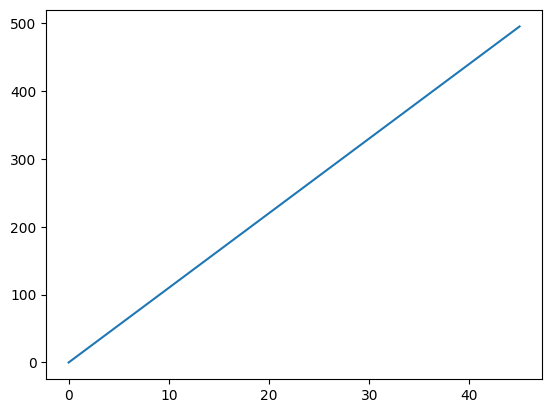

In [771]:
plt.plot(last_upd)

In [772]:
tf.keras.models.save_model(observer, "obs_enc_model_tag_agent_500epochs_0001LR_5eps.keras")
tf.keras.models.save_model(observer_adv, "obs_enc_model_tag_adv_500epochs_0001LR_5eps.keras")

In [ ]:
post_train = return_avg_reward_tag(env, episodes=50)

In [ ]:
pre_train

In [ ]:
pre_train_mu.shape

In [ ]:
pre_train_mu_1.shape

In [ ]:
pre_train[0].shape

In [ ]:
pre_train[1].shape

In [ ]:
np.mean(pre_train[1].reshape((50,3,25)), axis=1).shape

In [ ]:
plt.figure(figsize=(10,8))

pre_train_mu = np.mean(pre_train[0], axis=0)
pre_train_std = np.std(pre_train[0], axis=0)

pre_train_mu_1 = np.mean(np.mean(pre_train[1].reshape(50,3,25), axis=1), axis=0)
pre_train_std_1 = np.mean(np.std(pre_train[1].reshape(50,3,25), axis=1), axis=0)


x = np.linspace(1,len(pre_train_mu),len(pre_train_mu))

observer = tf.keras.models.load_model("obs_enc_model_tag_agent_500epochs_scratch.keras", compile=False)
observer_adv = tf.keras.models.load_model("obs_enc_model_tag_adv_500epochs_scratch.keras", compile=False)
post_train = return_avg_reward_tag(env, episodes=50)

post_train_mu_1 = np.mean(post_train[0], axis=0)
post_train_std_1 = np.std(post_train[0], axis=0)

post_train_mu_2 = np.mean(np.mean(post_train[1].reshape(50,3,25), axis=1), axis=0)
post_train_std_2 = np.mean(np.std(post_train[1].reshape(50,3,25), axis=1), axis=0)

observer_1 = tf.keras.models.load_model("obs_enc_model_tag_agent_500epochs.keras", compile=False)
observer_adv_1 = tf.keras.models.load_model("obs_enc_model_tag_agent_500epochs.keras", compile=False)
post_train_1 = return_avg_reward_tag(env, episodes=50)

post_train_mu_3 = np.mean(post_train_1[0], axis=0)
post_train_std_3 = np.std(post_train_1[0], axis=0)

post_train_mu_4 = np.mean(np.mean(post_train_1[1].reshape(50,3,25), axis=1), axis=0)
post_train_std_4 = np.mean(np.std(post_train_1[1].reshape(50,3,25), axis=1), axis=0)

plt.plot(x, pre_train_mu, label='Agent - Before training', color='b')
# plt.plot(x, pre_train_mu_1, label='Adv - Before training', color='c')
plt.plot(x, post_train_mu_1, label='Agent - From scratch', color='g')
# plt.plot(x, post_train_mu_2, label='Advesary - From scratch', color='y')
plt.plot(x, post_train_mu_3, label='Agent - Copying 16 bit comms', color='r')
# plt.plot(x, post_train_mu_4, label='Adv - Copying 16 bit comms', color='k')
plt.fill_between(x, pre_train_mu - pre_train_std, pre_train_mu + pre_train_std, alpha=0.4, color='b')
# plt.fill_between(x, pre_train_mu_1 - pre_train_std_1, pre_train_mu_1 + pre_train_std_1, alpha=0.4, color='c')
plt.fill_between(x, post_train_mu_1 - post_train_std_1, post_train_mu_1 + post_train_std_1, alpha=0.4, color='g')
# plt.fill_between(x, post_train_mu_2 - post_train_std_2, post_train_mu_2 + post_train_std_2, alpha=0.4, color='y')
plt.fill_between(x, post_train_mu_3 - post_train_std_3, post_train_mu_3 + post_train_std_3, alpha=0.4, color='r')
# plt.fill_between(x, post_train_mu_4 - post_train_std_4, post_train_mu_4 + post_train_std_4, alpha=0.4, color='k')
plt.xlabel("Step No.", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.ylim(-20, 6)
plt.title("Reward plot average across 50 episodes - Communication Generalizability", fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [ ]:
sum_pre_train = [np.sum(i) for i in pre_train[0]]
sum_post_train = [np.sum(i) for i in post_train[0]]
sum_post_train_1 = [np.sum(i) for i in post_train_1[0]]

In [ ]:
print(np.mean(sum_pre_train), ", ", np.std(sum_pre_train))
print("Scratch = ",np.mean(sum_post_train), ", ", np.std(sum_post_train))
print("Communication copy = ", np.mean(sum_post_train_1), ", ", np.std(sum_post_train_1))

In [ ]:
tf.keras.models.save_model(observer, "obs_enc_model_tag_agent_500epochs_scratch.keras")
tf.keras.models.save_model(observer_adv, "obs_enc_model_tag_adv_500epochs_scratch.keras")

### Comm analysis

In [203]:
observer = tf.keras.models.load_model("obs_enc_model_tag_agent_500epochs.keras", compile=False)
observer_adv = tf.keras.models.load_model("obs_enc_model_tag_adv_500epochs.keras", compile=False)

In [204]:
def single_ep_tag_analyse(agent_model,adv_model, env, eps):
    local_memory = []
    rews_ep = []
    local_memory_adv = []
    rews_ep_adv = []
    for agent in env.agent_iter():
        state, reward, termination, truncation, info = env.last()
        if termination or truncation:
            action_ = None
        elif not "agent" in agent:
            if random.random() < eps:
                action_ = env.action_space(agent).sample()
                comm = None
            else:
                op1, comm = adv_model(np.array([state]), return_comm_bits=True)
 
                action_ = tf.argmax(op1, axis=1).numpy()[0]
        else:
            # map_i = np.array([env.render()])
            if random.random() < eps:
                action_ = env.action_space(agent).sample()
                comm = None
            else:
                op1, comm = agent_model(np.array([state]), return_comm_bits=True)
 
                action_ = tf.argmax(op1, axis=1).numpy()[0]
        
        ret = env.step(action_)
        if action_ == None:
            break
        
        if "agent" in agent:
            # new_state, new_reward, _, _, info = env.last()
            new_state = env.observe(agent)
            new_reward = env.rewards.get(agent, 0)
            local_memory.append([
                state, action_, new_reward, new_state, comm
            ])
            rews_ep.append(new_reward)
        else:
            new_state = env.observe(agent)
            new_reward = env.rewards.get(agent, 0)
            local_memory_adv.append([
                state, action_, new_reward, new_state, comm
            ])
            rews_ep_adv.append(new_reward)
            
    return local_memory, np.array(rews_ep), local_memory_adv, np.array(rews_ep_adv)

In [205]:
def get_communication_props(observer,observer_adv, no_eps=1000):
    temp_mem = []
    temp_mem_adv = []
    for i in tqdm(range(no_eps)):
        env.reset()
        ret = single_ep_tag_analyse(observer, observer_adv, env, 0)
        temp_mem.extend(ret[0])
        temp_mem.extend(ret[2])

    memory = copy.deepcopy(temp_mem)
    
    acts = [mem[1] for mem in memory]

    comm_dict = {}
    comm_dict_non_zero = {}
    comm_arrs = np.ones((len(memory))) * -1
    for i in range(len(memory)):
        s_i, a_i, r_i, s_j, comm_i = memory[i]
        if comm_i == None:
            continue
        comm_i = comm_i.numpy()[0].astype(int)
        key_comm = ''.join([str(x) for x in comm_i])
        if comm_dict.get(key_comm) is None:
            comm_dict[key_comm] = copy.deepcopy(comm_arrs)
            comm_arrs[i] = copy.deepcopy(a_i)
    
            comm_dict_non_zero[key_comm] = [a_i]
        else:
            comm_dict[key_comm][i] = a_i
    
            comm_dict_non_zero[key_comm].append(a_i)

    counter_comms = {}
    for i in comm_dict.keys():
        counter_comms[i] = dict(Counter(comm_dict_non_zero[i]))

    comm_prop_dict = {}
    for i in counter_comms.keys():
        temp = sum(list(counter_comms[i].values()))
        temp_prop = {
            x:counter_comms[i][x] / temp for x in counter_comms[i].keys()
        }
        comm_prop_dict[i] = temp_prop

    agent_comm = copy.deepcopy(comm_prop_dict)
    memory = copy.deepcopy(temp_mem_adv)
    acts = [mem[1] for mem in memory]

    comm_dict = {}
    comm_dict_non_zero = {}
    comm_arrs = np.ones((len(memory))) * -1
    for i in range(len(memory)):
        s_i, a_i, r_i, s_j, comm_i = memory[i]
        if comm_i == None:
            continue
        comm_i = comm_i.numpy()[0].astype(int)
        key_comm = ''.join([str(x) for x in comm_i])
        if comm_dict.get(key_comm) is None:
            comm_dict[key_comm] = copy.deepcopy(comm_arrs)
            comm_arrs[i] = copy.deepcopy(a_i)
    
            comm_dict_non_zero[key_comm] = [a_i]
        else:
            comm_dict[key_comm][i] = a_i
    
            comm_dict_non_zero[key_comm].append(a_i)

    counter_comms = {}
    for i in comm_dict.keys():
        counter_comms[i] = dict(Counter(comm_dict_non_zero[i]))

    comm_prop_dict = {}
    for i in counter_comms.keys():
        temp = sum(list(counter_comms[i].values()))
        temp_prop = {
            x:counter_comms[i][x] / temp for x in counter_comms[i].keys()
        }
        comm_prop_dict[i] = temp_prop

    return agent_comm, comm_prop_dict

In [206]:
observer.summary()

Model: "observer_explorer_encoder_tag_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_84 (Sequential)  (None, 16)                4864      
                                                                 
 sequential_85 (Sequential)  (None, 5)                 1333      
                                                                 
Total params: 6197 (24.21 KB)
Trainable params: 6197 (24.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [209]:
comm_prop_dict_1 = get_communication_props(observer, observer_adv)

  8%|███▎                                     | 81/1000 [00:16<03:07,  4.89it/s]


KeyboardInterrupt: 

In [ ]:
comm_prop_agent, comm_prop_adv = comm_prop_dict_1

In [778]:
with open('comm_prop_agent.pkl', 'wb') as file:  
	pickle.dump(comm_prop_agent, file) 

In [749]:
model = tf.keras.models.load_model("obs_enc_model_16bit.keras", compile=False)
comm_prop_base = get_communication_props(model)

100%|███████████████████████████████████████| 1000/1000 [01:30<00:00, 11.03it/s]


In [750]:
model.summary()

Model: "observer_explorer_encoder_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_343 (Sequential  (None, 16)                4224      
 )                                                               
                                                                 
 sequential_344 (Sequential  (None, 5)                 1333      
 )                                                               
                                                                 
Total params: 5557 (21.71 KB)
Trainable params: 5557 (21.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [751]:
with open('comm_prop_base.pkl', 'wb') as file:  
	pickle.dump(comm_prop_base, file) 

In [210]:
with open('comm_prop_agent.pkl', 'rb') as file:
	comm_prop_agent = pickle.load(file) 

with open('comm_prop_base.pkl', 'rb') as file:
	comm_prop_base = pickle.load(file) 

In [211]:
len(comm_prop_base.keys())

230

In [212]:
len(comm_prop_agent.keys())

7255

In [213]:
present_1_only = []
present_2_only = []
common_seqs = []
comm_1 = list(comm_prop_base.keys())
comm_2 = list(comm_prop_agent.keys())

for i in comm_1:
    if i in comm_2:
        common_seqs.append(i)
    else:
        present_1_only.append(i)

for i in comm_2:
    if not i in comm_1:
        present_2_only.append(i)

In [214]:
len(present_1_only)

186

In [215]:
len(present_2_only)

7211

In [216]:
len(common_seqs)

44

In [217]:
comm_act = 0
for i in common_seqs:
    print(i)
    if list(comm_prop_base[i].keys())[0] == list(comm_prop_agent[i].keys())[0]:
        print(i)
        comm_act +=1

0100001100100111
0100001100100111
1111001101110101
1111001101110101
0110001110110101
0111001011010000
0111001011110100
0011001011110110
0011001011100110
0011001011100110
0111001011110000
0111001010110000
0110001101100101
0110001101100101
0110001110100101
0111001011100110
0111001011100110
0000000100100111
0000000100100111
1111001101100101
1111001101100101
1000101101000001
1000101101000001
0111001010110010
0111001010110010
0011001011100111
0011001011100111
1111001001110101
1111001001110101
0111001011110110
0111001011100111
0111001011100111
1010001101100111
1010001101100111
0111001111100111
0111001111100111
0110001101110101
0110001101110101
0111001011110010
0111001011110010
1110001001110101
0110000100100110
0111001011110001
0111001011110001
0111001001110101
0110001100100101
0110001100100101
0110000100100111
1010001100100111
1010001100100111
0111001111100110
0111001111100110
0111001110110101
1100001100100111
1100001100100111
0110001010110010
1110001101100101
1110001101100101
11100110011101

In [218]:
comm_act

26

In [219]:
comm_prop_base

{'0100000100100110': {4: 1.0},
 '0100000100100111': {4: 1.0},
 '0100001100100111': {4: 1.0},
 '0100001101100101': {4: 1.0},
 '1100001101100101': {4: 1.0},
 '1100001101000101': {4: 1.0},
 '1000101001000001': {3: 1.0},
 '1111111001010001': {3: 1.0},
 '1111111011010001': {3: 1.0},
 '1011101011011011': {3: 1.0},
 '1011001011010001': {3: 1.0},
 '0011001011010010': {3: 1.0},
 '0011001011110010': {4: 1.0},
 '1011001111000011': {4: 1.0},
 '1010001101001011': {4: 1.0},
 '1010001101001111': {4: 1.0},
 '1011101101001001': {3: 1.0},
 '1011101011011001': {3: 1.0},
 '1011111011010001': {3: 1.0},
 '1011101011010001': {3: 1.0},
 '0011001011010001': {3: 1.0},
 '0011001011010000': {3: 1.0},
 '1111001101110101': {4: 1.0},
 '1000001101000101': {4: 1.0},
 '1000001101001001': {4: 1.0},
 '1000101001001001': {3: 1.0},
 '1111011011010001': {3: 1.0},
 '0111011011010001': {0: 1.0},
 '0111011011110101': {0: 1.0},
 '0111001011110101': {0: 1.0},
 '0111001111110101': {2: 1.0},
 '0110001110110101': {0: 1.0},
 '011000

In [220]:
comm_prop_agent

{'1010111101100101': {2: 1.0},
 '1110111101100101': {0: 1.0},
 '1110101101100100': {4: 1.0},
 '1110101101100000': {4: 1.0},
 '1111111101100000': {4: 1.0},
 '1110111101100000': {4: 1.0},
 '1110111101100001': {2: 1.0},
 '1110111001000000': {3: 1.0},
 '1100111100000000': {4: 1.0},
 '1110111001000010': {3: 1.0},
 '0110111100100010': {0: 1.0},
 '0110101100100010': {4: 1.0},
 '1110101000100010': {4: 1.0},
 '1110101000000010': {4: 1.0},
 '1110111000000010': {2: 1.0},
 '1110111010000010': {2: 1.0},
 '1100111010000010': {2: 1.0},
 '0111101010000010': {4: 1.0},
 '1101011101110110': {4: 1.0},
 '1001001001010110': {4: 1.0},
 '0111101011000010': {4: 1.0},
 '1101001101110110': {4: 1.0},
 '1100001101110110': {4: 1.0},
 '1001001101010110': {4: 1.0},
 '0111101011000110': {4: 1.0},
 '1100001101110111': {4: 1.0},
 '1011001101010110': {4: 1.0},
 '1101001101110111': {4: 1.0},
 '1011001101110110': {4: 1.0},
 '0111001011110110': {4: 1.0},
 '1111001101110111': {4: 1.0},
 '0110001011110110': {2: 1.0},
 '111100

In [221]:
rev_comm_prop = {
    0:[],
    1:[],
    2:[],
    3:[],
    4:[]
}

In [222]:
lens_comms = [0]
for i in comm_prop_agent.keys():
    vals = comm_prop_agent[i]
    ids, props = list(vals.keys()),list(vals.values())
    max_idx = np.where(np.array(props) > 0.5)[0]
    if len(max_idx)  > 0:
        rev_comm_prop[ids[max_idx[0]]].append(i)

In [223]:
for i in rev_comm_prop.keys():
    print(len(rev_comm_prop[i]))

1111
0
974
849
4297


In [224]:
rev_comm_prop.keys()

dict_keys([0, 1, 2, 3, 4])

In [225]:
shd_vals = []
shd_lens = [0]
for i in rev_comm_prop.keys():
    shd_vals.extend(rev_comm_prop[i])
    shd_lens.append(shd_lens[-1] + len(rev_comm_prop[i]))
# shd_lens = shd_lens[1:]

In [226]:
len(shd_vals)

7231

In [227]:
shd_lens

[0, 1111, 1111, 2085, 2934, 7231]

In [228]:
img_colors = np.zeros((shd_lens[-1], shd_lens[-1], 3))
for i in range(len(shd_lens)-1):
    img_colors[shd_lens[i]:shd_lens[i+1], shd_lens[i]:shd_lens[i+1]] = [255,0,0]

In [229]:
def cmp_str(s1, s2):
    base_chng = 0
    for i in range(len(s1)):
        if s1[i] != s2[i]:
            base_chng +=1
    return base_chng

In [230]:
shd_matrix = np.zeros((shd_lens[-1], shd_lens[-1]))
for i in tqdm(range(len(shd_vals))):
    for j in range(len(shd_vals)):
        if i == j:
            continue
        if len(shd_vals[i]) != len(shd_vals[j]):
            print(len(shd_vals[i]) - len(shd_vals[j]))
        shd_matrix[i][j] = cmp_str(shd_vals[i], shd_vals[j])

100%|██████████████████████████████████████| 7231/7231 [00:57<00:00, 124.89it/s]


In [231]:
shd_lens

[0, 1111, 1111, 2085, 2934, 7231]

In [232]:
np.linspace(shd_lens[0],shd_lens[1],shd_lens[1]+1)

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.109e+03, 1.110e+03,
       1.111e+03])

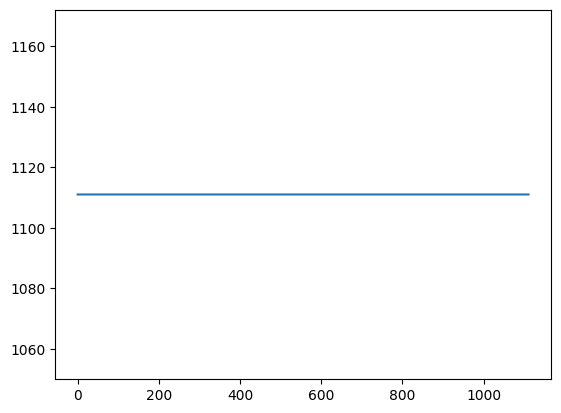

In [233]:
plt.plot(np.linspace(shd_lens[0], shd_lens[1], shd_lens[1]+1), [shd_lens[1]]*(shd_lens[1]+1))

In [234]:
from matplotlib import patches

In [235]:
shd_lens[3]

2085

In [236]:
shd_lens[4]

2934

In [237]:
shd_matrix.shape

(7231, 7231)

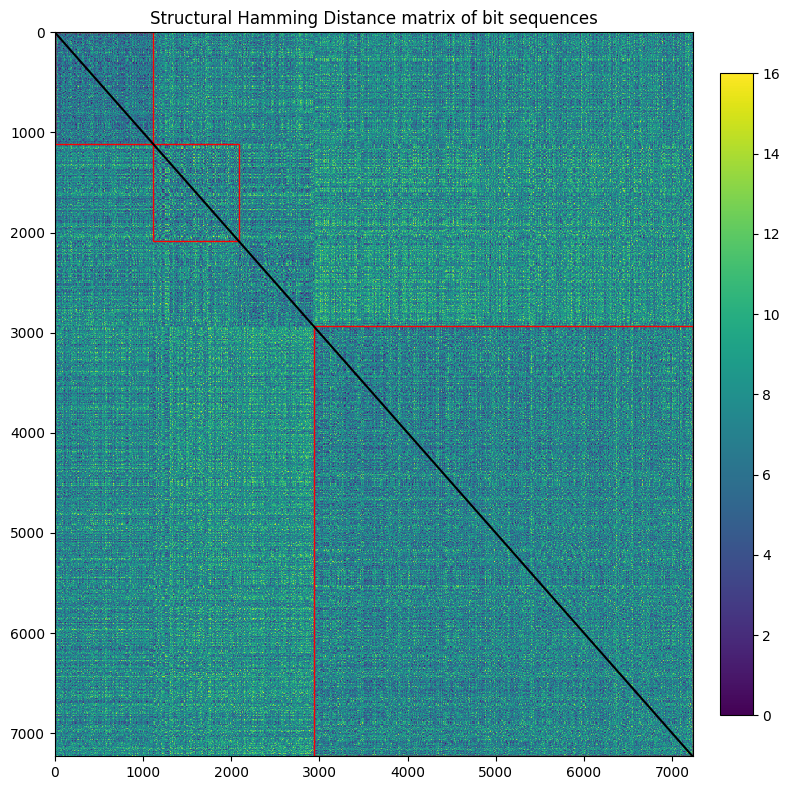

In [238]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(shd_matrix, interpolation='none', alpha=1, aspect='auto')
ax.plot(np.linspace(0,shd_matrix.shape[0], shd_matrix.shape[0]+1),np.linspace(0,shd_matrix.shape[0], shd_matrix.shape[0]+1), 'k')
rect = patches.Rectangle((shd_lens[0],0), shd_lens[1], shd_lens[1], linewidth=1, edgecolor='r', facecolor='none')
rect1 = patches.Rectangle((shd_lens[1],shd_lens[1]), shd_lens[2]-shd_lens[1], shd_lens[2]-shd_lens[1], linewidth=1, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((shd_lens[2],shd_lens[2]), shd_lens[3]-shd_lens[2], shd_lens[3]-shd_lens[2], linewidth=1, edgecolor='r', facecolor='none')
rect3 = patches.Rectangle((shd_lens[4],shd_lens[4]), shd_lens[5]-shd_lens[4], shd_lens[5]-shd_lens[4], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.set_title("Structural Hamming Distance matrix of bit sequences")
ax.axes.set_xlim(right=shd_matrix.shape[0])
ax.axes.set_ylim(bottom=shd_matrix.shape[0])
plt.colorbar(im,fraction=0.046, pad=0.04)

# plt.plot(np.linspace(shd_lens[0],shd_lens[1],1), np.linspace(shd_lens[0],shd_lens[1],1), 'r')
# plt.vlines(x=shd_lens, ymin=0, ymax=shd_matrix.shape[0] - 1, colors='r', alpha=0.4)
# plt.hlines(y=shd_lens, xmin=0, xmax=shd_matrix.shape[0] - 1, colors='r', alpha=0.4)
plt.tight_layout()
plt.show()

In [239]:
intra_mean_shd = []
inter_mean_shd = []

for i in range(len(rev_comm_prop.keys())):
    for j in range(i, len(rev_comm_prop.keys())):
        sub_matrix = shd_matrix[shd_lens[i]:shd_lens[i+1], shd_lens[j]:shd_lens[j+1]]
        if not np.mean(sub_matrix) >0:
            continue
        if i == j:
            intra_mean_shd.append(np.mean(sub_matrix))
        else:
            inter_mean_shd.append(np.mean(sub_matrix))

/Users/amogh/Projects/tensorflow-test/env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/amogh/Projects/tensorflow-test/env/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [240]:
inter_mean_shd

[7.517078607244708,
 7.488688444816213,
 7.501058134670809,
 7.540195857912316,
 7.967447323690326,
 8.175900791441586]

In [241]:
intra_mean_shd

[6.318132803379348, 7.405913083075782, 6.884158040846225, 7.225333725371068]

In [242]:
np.mean(intra_mean_shd)

6.958384413168106

In [243]:
np.mean(inter_mean_shd)

7.698394859962661

In [244]:
(np.mean(intra_mean_shd) - np.mean(inter_mean_shd)) / (np.var(intra_mean_shd) / len(intra_mean_shd) + np.var(inter_mean_shd)/len(inter_mean_shd))**0.5

-3.1499178151377367

In [245]:
stats.ttest_ind(intra_mean_shd, inter_mean_shd)

Ttest_indResult(statistic=-3.052782424797082, pvalue=0.015754312707564104)

## Use 16 bit model for FrozenLake

In [ ]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode='ansi')

In [ ]:
env.reset()

In [ ]:
ret = env.render()

In [ ]:
temp = np.array([gen_int_map(ret)])
start_pos = env.reset()[0]

In [ ]:
def gen_int_map(ansi_map, curr_pos, dim=4):
    env_map = np.zeros((dim,dim), dtype=int)
    pos_int = {
        "S":1,
        "F":1,
        "H":2,
        "G":3
    }
    ct = 0
    for i in range(len(ret)):
        if ret[i] in pos_int.keys():
            env_map[ct//dim][ct%dim] = int(pos_int[ret[i]])
                
            ct+=1
    env_map[int(curr_pos) // 4][int(curr_pos) % 4] = 0
    return env_map.flatten()

In [ ]:
def neg_check(tup, size):
    if (tup[0] < 0 or tup[1] < 0) or (tup[0] >= size or tup[1] >= size):
        return True
    return False

In [ ]:
def return_avg_reward_fl(env, episodes=10, plot=False):
    rews = []
    for i in range(episodes):
        env.reset()
        a,b = single_ep_fl(env, 0)
        rews.append(b)
    if plot:
        plt.plot(b)
        plt.show()
    return np.array(rews)

In [ ]:
def get_neighbour_fl(env_map):
    curr_idx = (np.where(env_map==0)[0][0], np.where(env_map==0)[1][0])
    left = np.subtract(curr_idx,(0,1))
    right = np.add(curr_idx,(0,1))
    up = np.subtract(curr_idx,(1,0))
    down = np.add(curr_idx, (1,0))
    arr_state = np.array([
        -1 if neg_check(left,env_map.shape[0]) else env_map[left[0]][left[1]],
        -1 if neg_check(right,env_map.shape[0]) else env_map[right[0]][right[1]],
        -1 if neg_check(up,env_map.shape[0]) else env_map[up[0]][up[1]],
        -1 if neg_check(down,env_map.shape[0]) else env_map[down[0]][down[1]]
    ])
    return arr_state

In [ ]:
def single_ep_fl(env, eps):
    local_memory = []
    rews_ep = []
    done, terminated = False, False
    last_pos = env.reset()[0]
    while not (done or terminated):
        map_i = np.array([gen_int_map(env.render(), last_pos)])
        map_i = map_i.reshape(int(map_i.shape[1]** 0.5),int(map_i.shape[1] ** 0.5))
        state_ = get_neighbour_fl(map_i)
        if random.random() < eps:
            action_ = random.randint(0,4)
            comm = None
        else:
            op1, comm = observer(np.array([state_]), return_comm_bits=True)
    
            action_ = tf.argmax(op1, axis=1).numpy()[0]
        if action_ == 0:
            new_state = state_
            new_reward = 0
            done, terminated = False, False
        else:
            new_pos, new_reward, done, terminated, _= env.step(action_ - 1)
            last_pos = new_pos
            map_j = np.array([gen_int_map(env.render(), last_pos)])
            map_j = map_j.reshape(int(map_j.shape[1]** 0.5),int(map_j.shape[1] ** 0.5))
            new_state = get_neighbour_fl(map_j)
        if (done or terminated) and new_reward == 0:
            new_reward = -1
        local_memory.append([
            state_, action_, new_reward, new_state, comm
        ])
        
        rews_ep.append(new_reward)
    return local_memory, np.array(rews_ep)
# if action_ == None:
#     break
# new_state, new_reward, _, _, _ = env.last()

# local_memory.append([
#     state, action_-1, -1 * new_reward, new_state, comm
# ])
# rews_ep.append(new_reward)
#     return local_memory, np.array(rews_ep)

In [ ]:
COMM_BITS = 16

In [ ]:
model = tf.keras.models.load_model("obs_enc_model_" + str(COMM_BITS) + "bit.keras", compile=False)

In [ ]:
observer = model

In [ ]:
observer.summary()

In [ ]:
# env = simple_v3.env(render_mode="rgb_array")
env.reset()

memory = []
large_memory = []
eps = 0.9
eps_vals = []
avg_rew = []

opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)
opt2 = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)

# observer = observer_explorer_encoder(COMM_BITS)
observer_ref = observer_explorer_encoder(COMM_BITS)

observer_ref.set_weights(observer)

observer.compile(
    optimizer=opt,
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse']
)

observer_ref.compile(
    optimizer=opt2,
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse']
)

save_checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model_training.tf", monitor='mse', save_best_only=True)

In [ ]:
pre_train = return_avg_reward_fl(env, episodes=20)

In [ ]:
last_upd = [0]
for i in tqdm(range(100)):
    env.reset()
    a, b = single_ep_fl(env, eps)
    memory.extend(a)
    avg_rew.append(b)
    eps_vals.append(eps)
    eps *= 0.99
    

    if len(memory) < 200:
        continue
    minibatch = random.sample(memory, 200)
    targets = []
    states = []
    for mem_i in minibatch:
        s_i, a_i, r_i, s_j, _ = mem_i
        yj = r_i + tf.math.scalar_mul(0.7, tf.cast(tf.argmax(observer_ref(np.array([s_j]))[0]), dtype=tf.float32))
        y_i = observer(np.array([s_i]))
        y_i = y_i.numpy()
        y_i[0][a_i] = yj
        targets.append(y_i[0])
        states.append(s_i)
    states = np.array(states)
    targets = np.array(targets)
    observer.fit(states, targets, epochs=1, shuffle=True, callbacks=[save_checkpoint])
    if i - last_upd[-1] > 10:
        observer_ref.set_weights(observer)
        last_upd.append(i)
    large_memory.extend(memory)
    # memory = []

In [ ]:
plt.plot(last_upd)

In [ ]:
plt.plot(eps_vals)

In [ ]:
post_train = return_avg_reward_fl(env, episodes=50)

In [ ]:
plt.figure(figsize=(10,8))

pre_train_mu = np.mean(pre_train, axis=0)
pre_train_std = np.std(pre_train, axis=0)

x = np.linspace(1,len(pre_train_mu),len(pre_train_mu))

post_train_mu = np.mean(post_train, axis=0)
post_train_std = np.std(post_train, axis=0)

plt.plot(x, pre_train_mu, label='Before training', color='b')
plt.plot(x, post_train_mu, label='After training', color='g')
plt.fill_between(x, pre_train_mu - pre_train_std, pre_train_mu + pre_train_std, alpha=0.4, color='b')
plt.fill_between(x, post_train_mu - post_train_std, post_train_std + post_train_std, alpha=0.4, color='g')
plt.xlabel("Step No.", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.ylim(-20, 6)
plt.title("Rewards for 25 steps across 50 episodes", fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [ ]:
sum_pre_train = [np.sum(i) for i in pre_train]
sum_post_train = [np.sum(i) for i in post_train]

In [ ]:
print(np.mean(sum_pre_train), ", ", np.std(sum_pre_train))
print(np.mean(sum_post_train), ", ", np.std(sum_post_train))

In [ ]:
plt.plot(eps_vals)

In [ ]:
rand_seed = random.randint(0,10000)

In [ ]:
env.reset()
rews = [i[2] for i in single_ep_fl(env,0)[0]]
plt.plot(rews)

In [ ]:
env.reset()
acts = [i[1] for i in single_ep_fl(env,0)[0]]
plt.plot(acts)

## Misc

In [ ]:
temp = [comm_prop_dict[i].get(0) if not comm_prop_dict[i].get(0) is None else 0  for i in comm_prop_dict.keys()]
temp1 = [comm_prop_dict[i].get(1) if not comm_prop_dict[i].get(1) is None else 0  for i in comm_prop_dict.keys()]
temp2 = [comm_prop_dict[i].get(2) if not comm_prop_dict[i].get(2) is None else 0  for i in comm_prop_dict.keys()]
temp3 = [comm_prop_dict[i].get(3) if not comm_prop_dict[i].get(3) is None else 0  for i in comm_prop_dict.keys()]
temp4 = [comm_prop_dict[i].get(4) if not comm_prop_dict[i].get(4) is None else 0  for i in comm_prop_dict.keys()]

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(list(range(len(comm_dict.keys()))), temp, label='0')
plt.bar(list(range(len(comm_dict.keys()))), temp1, label='1')
plt.bar(list(range(len(comm_dict.keys()))), temp2, label='2')
plt.bar(list(range(len(comm_dict.keys()))), temp3, label='3')
plt.bar(list(range(len(comm_dict.keys()))), temp4, label='4')
plt.legend()
plt.title("Actions for each bit sequence")
plt.show()

In [ ]:
for i in comm_dict.keys():
    plt.plot(comm_dict[i])
    plt.title(i + " - " + str(int(i,2)) + " - " + chr(int(i,2)))
    plt.show()

In [ ]:
## 1000 to 2500 bits only
for i in comm_dict.keys():
    plt.plot(comm_dict[i][1000:])
    plt.title(i + " - " + str(int(i,2)) + " - " + chr(int(i,2)))
    plt.show()

In [ ]:
len(comm_dict.keys())

In [ ]:
acts_comp = []
for i in range(10):
    env.reset()
    ret, _ = single_ep(env, 0)
    rews = [i[2] for i in ret]
    acts = [i[1] / 5 for i in ret]
    acts_comp.extend(acts)
    plt.plot(rews, label="Rewards")
    plt.plot(acts, label="Action(Scaled)")
    plt.legend()
    plt.show()

In [ ]:
plt.figure(figsize=(10,8))

pre_train_mu = np.mean(pre_train, axis=0)
pre_train_std = np.std(pre_train, axis=0)

x = np.linspace(1,len(pre_train_mu),len(pre_train_mu))

post_train_mu = np.mean(post_train, axis=0)
post_train_std = np.std(post_train, axis=0)

plt.plot(x, pre_train_mu, label='Before training', color='b')
plt.plot(x, post_train_mu, label='After training', color='g')
plt.fill_between(x, pre_train_mu - pre_train_std, pre_train_mu + pre_train_std, alpha=0.4, color='b')
plt.fill_between(x, post_train_mu - post_train_std, post_train_std + post_train_std, alpha=0.4, color='g')
plt.xlabel("Step No.", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.ylim(-20, 6)
plt.title("Rewards for 25 steps across 50 episodes", fontsize=16)
plt.legend(fontsize=12)
plt.show()